# 2-Stage In-Plane Rigid Registration: CT ↔ Ultrasound (CFRP) - Step-by-Step

## Overview

This notebook implements the **same 2-stage rigid registration pipeline** as `2_stage_xy_rz_reg.ipynb`, but with the registration process **broken down into individual cells** for step-by-step execution and debugging.

The registration is **constrained to in-plane motion only**:
- **Translations**: X (tx), Y (ty) — **free**
- **Rotation**: Z-axis (rz) — **optional** (configurable)
- **Locked DOF**: Z translation (tz) and X/Y rotations (rx, ry) are **fixed at zero**

### Workflow

1. **Environment Check & Dependencies**
2. **Configuration**  
3. **Load Utility Functions** (I/O, preprocessing, masks, resampling, etc.)
4. **Load Raw Volumes**
5. **Stage 1 Preprocessing** (coarse isotropic resampling)
6. **Stage 1 Registration** (coarse alignment)
7. **Stage 2 Preprocessing** (fine resolution)
8. **Stage 2 Registration** (fine alignment with in-plane constraints)
9. **Export Results** (warped volumes, transforms)
10. **Quality Control** (Dice, visualizations)

---

**Author**: Medical Imaging Registration Pipeline  
**Date**: 2025-10  
**Purpose**: Step-by-step registration for debugging and understanding


In [210]:
# Cell 1: Environment Check & Dependency Validation
# =====================================================

import sys
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

print("=" * 70)
print("ENVIRONMENT CHECK")
print("=" * 70)

# Check Python version
print(f"\nPython version: {sys.version}")
py_ver = sys.version_info
if py_ver.major < 3 or (py_ver.major == 3 and py_ver.minor < 10):
    print("⚠️  WARNING: Python 3.10+ recommended. You have {}.{}.{}".format(
        py_ver.major, py_ver.minor, py_ver.micro))
else:
    print(f"✓ Python {py_ver.major}.{py_ver.minor}.{py_ver.micro} (OK)")

print("\n" + "-" * 70)
print("DEPENDENCY VERSIONS")
print("-" * 70)

# Core dependencies
try:
    import numpy as np
    print(f"✓ NumPy: {np.__version__}")
except ImportError:
    print("✗ NumPy: NOT FOUND")
    sys.exit(1)

try:
    import scipy
    print(f"✓ SciPy: {scipy.__version__}")
except ImportError:
    print("✗ SciPy: NOT FOUND")
    sys.exit(1)

try:
    import matplotlib
    print(f"✓ Matplotlib: {matplotlib.__version__}")
except ImportError:
    print("✗ Matplotlib: NOT FOUND")
    sys.exit(1)

try:
    import tifffile
    print(f"✓ tifffile: {tifffile.__version__}")
except ImportError:
    print("✗ tifffile: NOT FOUND (install with: pip install tifffile)")
    sys.exit(1)

# Critical: SimpleITK
try:
    import SimpleITK as sitk
    print(f"✓ SimpleITK: {sitk.Version.VersionString()}")
    print(f"  Build: {sitk.Version.BuildDate()}")
except ImportError:
    print("\n" + "!" * 70)
    print("✗ SimpleITK: NOT FOUND")
    print("!" * 70)
    print("\nSimpleITK is REQUIRED for this notebook.")
    print("\nInstallation instructions:")
    print("  conda install -c simpleitk simpleitk")
    print("  OR")
    print("  pip install SimpleITK")
    print("\nAfter installation, restart the kernel and re-run this cell.")
    print("!" * 70)
    sys.exit(1)

print("\n" + "=" * 70)
print("✓ ALL DEPENDENCIES AVAILABLE")
print("=" * 70)
print("\nYou can now proceed to configure and run the registration pipeline.\n")


ENVIRONMENT CHECK

Python version: 3.13.7 | packaged by Anaconda, Inc. | (main, Sep  9 2025, 19:59:03) [GCC 11.2.0]
✓ Python 3.13.7 (OK)

----------------------------------------------------------------------
DEPENDENCY VERSIONS
----------------------------------------------------------------------
✓ NumPy: 2.2.6
✓ SciPy: 1.16.2
✓ Matplotlib: 3.10.7
✓ tifffile: 2025.10.16
✓ SimpleITK: 2.5.2
  Build: Jun 13 2025 19:16:44

✓ ALL DEPENDENCIES AVAILABLE

You can now proceed to configure and run the registration pipeline.



In [ ]:
# Cell 2: CONFIGURATION — Edit this cell only!
# ==============================================
RESOLUTIONS = {
    'CT_SPACING_MM': (0.025, 0.025, 0.025),  # Isotropic CT
    'US_SPACING_MM': (0.016, 1.0, 1.0),      # Anisotropic US
}
CONFIG = {
    # PATHS
    'CT_PATH': '/home/jorgecabrejas/Dev/Data/JI_7_aligned_90rotright_reslicetop.tif',
    'US_PATH': '/home/jorgecabrejas/Dev/Data/envelope.tif',
    'OUTPUT_DIR': './outputs/registration_stepwise',
    
    # PHYSICAL SPACINGS (mm) — Format: (dz, dy, dx)
    'CT_SPACING_MM': RESOLUTIONS['CT_SPACING_MM'],  # Isotropic CT
    'US_SPACING_MM': RESOLUTIONS['US_SPACING_MM'],      # Anisotropic US
    
    # STAGE 1: COARSE ALIGNMENT
    'STAGE1_SPACING_MM': 0.8,  # Coarse isotropic spacing
    
    # STAGE 2: FINE ALIGNMENT
    'STAGE2_CT_SPACING_MM': (RESOLUTIONS['US_SPACING_MM'][2], RESOLUTIONS['US_SPACING_MM'][1], RESOLUTIONS['CT_SPACING_MM'][0]),  # Match US in-plane, keep native CT Z
    'STAGE2_US_KEEP_NATIVE': True,     # Keep US at native resolution
    
    # DEGREES OF FREEDOM
    'ALLOW_RZ': True,  # Allow in-plane rotation
    
    # PREPROCESSING
    'CT_CLIP_PERCENTILES': (2, 98),
    'US_GAUSSIAN_SIGMA_VOXELS': 0.5,
    'US_CLIP_PERCENTILES': (0, 100),
    'US_LOG_COMPRESSION': False,
    
    # REGISTRATION HYPERPARAMETERS
    'MI_BINS': 64,
    'SAMPLING_PERCENT': 0.35,
    'SHRINK_FACTORS': [3, 2, 1],
    'SMOOTHING_SIGMAS_MM': [2.5, 1.5, 0.0],
    'MAX_ITERS_PER_LEVEL': 1000,
    'LEARNING_RATE': 2.0,
    'MIN_STEP_LENGTH': 1e-6,
    'RELAXATION_FACTOR': 0.5,
    'RANDOM_SEED': 42,
    'QC_NUM_SLICES': 7,
}

print("✓ Configuration loaded successfully.")
print(f"  CT: {CONFIG['CT_PATH']}")
print(f"  US: {CONFIG['US_PATH']}")
print(f"  Output: {CONFIG['OUTPUT_DIR']}")
print(f"  In-plane rotation (Rz): {'ALLOWED' if CONFIG['ALLOW_RZ'] else 'LOCKED'}")


✓ Configuration loaded successfully.
  CT: /home/jorgecabrejas/Dev/Data/JI_7_aligned_90rotright_reslicetop.tif
  US: /home/jorgecabrejas/Dev/Data/envelope.tif
  Output: ./outputs/registration_stepwise
  In-plane rotation (Rz): ALLOWED


In [212]:
# Cell 3: Load All Utility Functions from Original Notebook
# ============================================================
# Import all utility modules from cells 3-10 of the original notebook

import os
import SimpleITK as sitk
import numpy as np
import tifffile
from pathlib import Path
import json
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from scipy.ndimage import label, binary_fill_holes
import sys
sys.path.append('/home/jorgecabrejas/Dev/UTvsXCT-preprocessing')
from preprocess_tools.onlypores import material_mask, material_mask_nonconcurrent

# ============================================================================
# I/O UTILITIES
# ============================================================================

def read_volume(path, spacing_mm=None, origin=None, direction=None):
    """Read 3D volume and convert to SimpleITK Image"""
    path = str(path)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Volume not found: {path}")
    
    if path.lower().endswith(('.tif', '.tiff')):
        arr = tifffile.imread(path)
        arr = arr.astype(np.float32)
        img = sitk.GetImageFromArray(arr)
    else:
        img = sitk.ReadImage(path)
        img = sitk.Cast(img, sitk.sitkFloat32)
    
    if spacing_mm is not None:
        img.SetSpacing(spacing_mm[::-1])
    elif img.GetSpacing() == (1.0, 1.0, 1.0):
        print(f"  ⚠️  WARNING: No spacing in file metadata for {Path(path).name}")
    
    if origin is not None:
        img.SetOrigin(origin[::-1])
    if direction is not None:
        img.SetDirection(direction)
    
    return img

def write_volume(img, path, compress=True):
    """Write SimpleITK Image to disk"""
    path = str(path)
    os.makedirs(os.path.dirname(path) or '.', exist_ok=True)
    
    if path.lower().endswith(('.tif', '.tiff')):
        arr = sitk.GetArrayFromImage(img)
        tifffile.imwrite(path, arr, compression='zlib' if compress else None)
    else:
        sitk.WriteImage(img, path, compress)
    print(f"  ✓ Saved: {path}")

def write_transform(transform, path):
    """Write SimpleITK Transform to disk"""
    path = str(path)
    os.makedirs(os.path.dirname(path) or '.', exist_ok=True)
    
    if isinstance(transform, sitk.CompositeTransform):
        path_h5 = path.replace('.tfm', '.h5')
        sitk.WriteTransform(transform, path_h5)
        print(f"  ✓ Saved transform: {path_h5}")
    else:
        try:
            sitk.WriteTransform(transform, path)
            print(f"  ✓ Saved transform: {path}")
        except Exception:
            path_h5 = path.replace('.tfm', '.h5')
            sitk.WriteTransform(transform, path_h5)
            print(f"  ✓ Saved transform (HDF5): {path_h5}")

# ============================================================================
# PREPROCESSING FUNCTIONS
# ============================================================================

def compute_percentiles(img_sitk, p_low, p_high):
    """Compute percentile values from SimpleITK Image"""
    arr = sitk.GetArrayFromImage(img_sitk)
    val_low = np.percentile(arr, p_low)
    val_high = np.percentile(arr, p_high)
    return val_low, val_high

def normalize_ct(img_sitk, percentiles=(2, 98)):
    """Normalize CT: percentile clip → [0,1]"""
    p_low, p_high = percentiles
    val_low, val_high = compute_percentiles(img_sitk, p_low, p_high)
    val_low = float(val_low)
    val_high = float(val_high)
    
    img_clipped = sitk.Clamp(img_sitk, sitk.sitkFloat32, val_low, val_high)
    
    if val_high > val_low:
        img_norm = (img_clipped - val_low) / (val_high - val_low)
    else:
        img_norm = img_clipped * 0.0
    
    return img_norm

def normalize_us(img_sitk, sigma_voxels=1.0, percentiles=(1, 99), log_compress=True):
    """Normalize US: smooth → clip → [0,1] → optional log"""
    if sigma_voxels > 0:
        img_smooth = sitk.SmoothingRecursiveGaussian(img_sitk, sigma_voxels)
    else:
        img_smooth = img_sitk
    
    p_low, p_high = percentiles
    val_low, val_high = compute_percentiles(img_smooth, p_low, p_high)
    val_low = float(val_low)
    val_high = float(val_high)
    
    img_clipped = sitk.Clamp(img_smooth, sitk.sitkFloat32, val_low, val_high)
    
    if val_high > val_low:
        img_scaled = (img_clipped - val_low) / (val_high - val_low)
    else:
        img_scaled = img_clipped * 0.0
    
    if log_compress:
        arr = sitk.GetArrayFromImage(img_scaled)
        arr_log = np.log1p(2.0 * arr)
        if arr_log.max() > 0:
            arr_log = arr_log / arr_log.max()
        img_log = sitk.GetImageFromArray(arr_log)
        img_log.CopyInformation(img_scaled)
        return img_log
    else:
        return img_scaled

# ============================================================================
# MASK GENERATION
# ============================================================================

def fill_holes_slice_by_slice(mask_array):
    """
    Fill holes in a 3D binary mask slice by slice along the Z-axis.
    
    This ensures that the largest components don't have holes inside them,
    which is important for accurate registration.
    
    Parameters:
    -----------
    mask_array : numpy.ndarray
        3D binary mask array (Z, Y, X)
    
    Returns:
    --------
    numpy.ndarray : Mask with holes filled
    """
    filled_mask = np.zeros_like(mask_array, dtype=bool)
    
    for z in range(mask_array.shape[0]):
        slice_2d = mask_array[z, :, :].astype(bool)
        if np.any(slice_2d):  # Only process non-empty slices
            filled_mask[z, :, :] = binary_fill_holes(slice_2d)
        else:
            filled_mask[z, :, :] = slice_2d
    
    return filled_mask.astype(np.uint8)

def create_ct_mask_from_original(img_sitk_original):
    """
    Create CT mask from original resolution volume using material_mask_nonconcurrent from onlypores.py
    
    This mask should be calculated on the original/native resolution data (NOT normalized),
    then resampled to match the target volume resolution.
    
    Uses the material_mask function which applies:
    - Otsu thresholding
    - Maximum projection analysis
    - Void filling for solid material boundaries
    """
    print("    CT mask: Using material_mask from onlypores.py at original resolution")
    
    # Convert SimpleITK image to numpy array
    ct_array = sitk.GetArrayFromImage(img_sitk_original)
    
    # Apply material_mask function from onlypores.py
    mask_array = material_mask_nonconcurrent(ct_array)
    
    # Fill holes slice by slice to ensure solid regions
    print("    Filling holes in CT mask slice by slice...")
    mask_array_filled = fill_holes_slice_by_slice(mask_array)
    holes_filled = np.sum(mask_array_filled) - np.sum(mask_array)
    if holes_filled > 0:
        print(f"    Filled {holes_filled:,} hole voxels")
    
    # Convert back to SimpleITK image
    mask = sitk.GetImageFromArray(mask_array_filled.astype(np.uint8))
    mask.CopyInformation(img_sitk_original)
    
    # Report statistics
    num_voxels = np.sum(mask_array_filled)
    total_voxels = np.prod(ct_array.shape)
    print(f"    Material mask: {num_voxels:,} voxels ({100*num_voxels/total_voxels:.1f}% of volume)")
    
    return mask

def create_us_mask_from_original(img_sitk_original_normalized, use_otsu_on_optimal_slice=True):
    """
    Create US mask from original resolution volume.
    
    This mask should be calculated on the original/native resolution data,
    then resampled to match the target volume resolution.
    
    If use_otsu_on_optimal_slice=True:
        1. Find the mean of the indices of max signal for each A-scan
        2. Apply Otsu thresholding (scikit-image) on that slice
        3. Replicate the 2D mask across all depth slices
    
    Otherwise: simple threshold across entire volume
    """
    if use_otsu_on_optimal_slice:
        # Convert to numpy array (Z, Y, X) where Z is depth
        arr = sitk.GetArrayFromImage(img_sitk_original_normalized)
        
        # Find index of maximum along depth axis (axis=0) for each lateral position
        max_indices = np.argmax(arr, axis=0)  # Shape: (Y, X)
        
        # Calculate mean index (the slice with strongest signal on average)
        optimal_slice_idx = int(np.round(np.mean(max_indices)))
        optimal_slice_idx = np.clip(optimal_slice_idx, 0, arr.shape[0] - 1)
        
        # Extract the optimal slice
        optimal_slice_arr = arr[optimal_slice_idx, :, :]  # Shape: (Y, X)
        
        # Apply Otsu thresholding using scikit-image
        otsu_thresh = threshold_otsu(optimal_slice_arr)
        mask_2d_arr = (optimal_slice_arr > otsu_thresh).astype(np.uint8)
        
        # Keep only the largest connected component
        labeled_array, num_features = label(mask_2d_arr)
        if num_features > 0:
            # Find the largest component (excluding background 0)
            component_sizes = np.bincount(labeled_array.ravel())
            component_sizes[0] = 0  # Exclude background
            largest_component_label = component_sizes.argmax()
            mask_2d_arr = (labeled_array == largest_component_label).astype(np.uint8)
            print(f"    US mask: Using Otsu (scikit-image) on slice {optimal_slice_idx}/{arr.shape[0]} "
                  f"at original resolution, threshold={otsu_thresh:.4f}")
            print(f"    Kept largest component ({component_sizes[largest_component_label]:,} pixels "
                  f"out of {num_features} components)")
        else:
            print(f"    US mask: Using Otsu (scikit-image) on slice {optimal_slice_idx}/{arr.shape[0]} "
                  f"at original resolution, threshold={otsu_thresh:.4f}")
            print(f"    WARNING: No components found in mask")
        
        # Fill holes in the 2D mask to ensure solid region
        mask_2d_before_fill = mask_2d_arr.copy()
        mask_2d_arr_filled = binary_fill_holes(mask_2d_arr.astype(bool)).astype(np.uint8)
        holes_filled_2d = np.sum(mask_2d_arr_filled) - np.sum(mask_2d_before_fill)
        if holes_filled_2d > 0:
            print(f"    Filled {holes_filled_2d:,} hole pixels in 2D mask")
        mask_2d_arr = mask_2d_arr_filled
        
        # Replicate this 2D mask across all depth slices
        mask_3d_arr = np.repeat(mask_2d_arr[np.newaxis, :, :], arr.shape[0], axis=0)
        
        # Convert back to SimpleITK image
        mask = sitk.GetImageFromArray(mask_3d_arr.astype(np.uint8))
        mask.CopyInformation(img_sitk_original_normalized)
    else:
        # Simple threshold approach
        threshold = 0.05
        mask = sitk.BinaryThreshold(img_sitk_original_normalized, threshold, 1.0, 1, 0)
        mask = sitk.Cast(mask, sitk.sitkUInt8)
    
    return mask

def resample_mask_to_target(mask_sitk, target_img_sitk):
    """
    Resample a mask to match the resolution and size of a target image.
    Uses nearest neighbor interpolation to preserve binary values.
    """
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(target_img_sitk)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    resampler.SetDefaultPixelValue(0)
    resampler.SetTransform(sitk.Transform())
    
    mask_resampled = resampler.Execute(mask_sitk)
    mask_resampled = sitk.Cast(mask_resampled, sitk.sitkUInt8)
    
    return mask_resampled

def find_optimal_ct_slice(ct_array, ct_mask_array=None):
    """
    Find the optimal CT slice where material is present.
    
    If mask is provided, uses center of mass of the mask.
    Otherwise, finds slice with maximum total intensity.
    
    Parameters:
    -----------
    ct_array : numpy.ndarray
        3D CT volume array (Z, Y, X)
    ct_mask_array : numpy.ndarray, optional
        3D CT mask array (Z, Y, X)
    
    Returns:
    --------
    int : Optimal slice index
    """
    if ct_mask_array is not None:
        # Use mask to find center of mass along Z axis
        z_projection = np.sum(ct_mask_array, axis=(1, 2))  # Sum over Y and X for each Z
        if np.sum(z_projection) > 0:
            # Weighted average (center of mass)
            z_indices = np.arange(len(z_projection))
            optimal_slice = int(np.round(np.sum(z_indices * z_projection) / np.sum(z_projection)))
        else:
            # Fallback to middle if mask is empty
            optimal_slice = ct_array.shape[0] // 2
    else:
        # Find slice with maximum total intensity
        z_projection = np.sum(ct_array, axis=(1, 2))
        optimal_slice = np.argmax(z_projection)
    
    optimal_slice = np.clip(optimal_slice, 0, ct_array.shape[0] - 1)
    return optimal_slice

# ============================================================================
# RESAMPLING UTILITIES
# ============================================================================

def resample_to_spacing(img, new_spacing, interpolator='linear'):
    """Resample image to new physical spacing"""
    original_spacing = img.GetSpacing()
    original_size = img.GetSize()
    
    new_size = [
        int(np.round(original_size[i] * original_spacing[i] / new_spacing[i]))
        for i in range(3)
    ]
    
    interp_map = {
        'linear': sitk.sitkLinear,
        'nearest': sitk.sitkNearestNeighbor,
        'bspline': sitk.sitkBSpline,
    }
    interp = interp_map.get(interpolator.lower(), sitk.sitkLinear)
    
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)
    resampler.SetOutputDirection(img.GetDirection())
    resampler.SetOutputOrigin(img.GetOrigin())
    resampler.SetTransform(sitk.Transform())
    resampler.SetDefaultPixelValue(0.0)
    resampler.SetInterpolator(interp)
    
    return resampler.Execute(img)

def resample_isotropic(img, iso_spacing, interpolator='linear'):
    """Resample image to isotropic spacing"""
    new_spacing = (iso_spacing, iso_spacing, iso_spacing)
    return resample_to_spacing(img, new_spacing, interpolator)

# ============================================================================
# DOF CONSTRAINTS
# ============================================================================

FREE_DOF_INPLANE_RZ = (False, False, True, True, True, False)
FREE_DOF_INPLANE_NO_RZ = (False, False, False, True, True, False)
FREE_DOF_FULL_6DOF = (True, True, True, True, True, True)

def constrain_euler3d_params(transform, free_dof_mask):
    """Zero out locked DOF parameters"""
    params = list(transform.GetParameters())
    for i, allow in enumerate(free_dof_mask):
        if not allow:
            params[i] = 0.0
    transform.SetParameters(params)
    return transform

def create_dof_constraint_callback(transform, free_dof_mask, verbose=False):
    """Create callback to enforce DOF constraints"""
    iteration_count = [0]
    
    def callback():
        constrain_euler3d_params(transform, free_dof_mask)
        iteration_count[0] += 1
        
        if verbose and iteration_count[0] % 20 == 0:
            params = transform.GetParameters()
            print(f"    Iter {iteration_count[0]:3d}: "
                  f"rx={np.rad2deg(params[0]):+7.3f}° "
                  f"ry={np.rad2deg(params[1]):+7.3f}° "
                  f"rz={np.rad2deg(params[2]):+7.3f}° "
                  f"tx={params[3]:+7.2f} ty={params[4]:+7.2f} tz={params[5]:+7.2f}")
    
    return callback

# ============================================================================
# VISUALIZATION UTILITIES
# ============================================================================

def extract_slice_indices(shape, num_slices=5, axis=0):
    """Extract evenly spaced slice indices"""
    max_idx = shape[axis]
    if num_slices >= max_idx:
        return list(range(max_idx))
    else:
        step = max_idx / (num_slices + 1)
        return [int(step * (i + 1)) for i in range(num_slices)]

def create_overlay_rgb(fixed_gray, moving_gray, alpha=0.5):
    """Create RGB overlay: fixed=magenta, moving=green"""
    fixed_gray = np.clip(fixed_gray, 0, 1)
    moving_gray = np.clip(moving_gray, 0, 1)
    
    rgb = np.zeros((*fixed_gray.shape, 3), dtype=np.float32)
    rgb[:, :, 0] = fixed_gray
    rgb[:, :, 1] = alpha * moving_gray
    rgb[:, :, 2] = fixed_gray
    
    rgb = (rgb * 255).astype(np.uint8)
    return rgb

# ============================================================================
# METRICS
# ============================================================================

def dice_coefficient(mask1, mask2):
    """Compute Dice coefficient"""
    if isinstance(mask1, sitk.Image):
        arr1 = sitk.GetArrayFromImage(mask1)
    else:
        arr1 = mask1
    
    if isinstance(mask2, sitk.Image):
        arr2 = sitk.GetArrayFromImage(mask2)
    else:
        arr2 = mask2
    
    arr1 = (arr1 > 0).astype(np.uint8)
    arr2 = (arr2 > 0).astype(np.uint8)
    
    intersection = np.sum(arr1 * arr2)
    size1 = np.sum(arr1)
    size2 = np.sum(arr2)
    
    if size1 + size2 == 0:
        return 0.0
    
    dice = 2.0 * intersection / (size1 + size2)
    return dice

print("✓ All utility functions loaded")


✓ All utility functions loaded


In [213]:
# STEP 1: Create Output Directory and Load Raw Volumes
# =======================================================

print("\n" + "="*70)
print("STEP 1: LOADING RAW VOLUMES")
print("="*70)

# Create output directory
out_dir = Path(CONFIG['OUTPUT_DIR'])
out_dir.mkdir(parents=True, exist_ok=True)
print(f"\n✓ Output directory: {out_dir}")

# Load CT volume
print(f"\nLoading CT from: {CONFIG['CT_PATH']}")
ct_raw = read_volume(CONFIG['CT_PATH'], spacing_mm=CONFIG['CT_SPACING_MM'])
print(f"  CT size: {ct_raw.GetSize()}")
print(f"  CT spacing: {ct_raw.GetSpacing()} mm")
print(f"  CT physical extent: {ct_raw.GetSize() * np.array(ct_raw.GetSpacing())} mm")

# Load US volume
print(f"\nLoading US from: {CONFIG['US_PATH']}")
us_raw = read_volume(CONFIG['US_PATH'], spacing_mm=CONFIG['US_SPACING_MM'])
print(f"  US size: {us_raw.GetSize()}")
print(f"  US spacing: {us_raw.GetSpacing()} mm")
print(f"  US physical extent: {np.array(us_raw.GetSize()) * np.array(us_raw.GetSpacing())} mm")

print("\n✓ Volumes loaded successfully")



STEP 1: LOADING RAW VOLUMES

✓ Output directory: outputs/registration_stepwise

Loading CT from: /home/jorgecabrejas/Dev/Data/JI_7_aligned_90rotright_reslicetop.tif
  CT size: (1618, 3282, 197)
  CT spacing: (0.025, 0.025, 0.025) mm
  CT physical extent: [40.45  82.05   4.925] mm

Loading US from: /home/jorgecabrejas/Dev/Data/envelope.tif
  US size: (65, 109, 500)
  US spacing: (1.0, 1.0, 0.016) mm
  US physical extent: [ 65. 109.   8.] mm

✓ Volumes loaded successfully


In [214]:
# STEP 2: Stage 1 Preprocessing (Coarse Isotropic)
# ===================================================

print("\n" + "="*70)
print("STEP 2: STAGE 1 PREPROCESSING (COARSE ISOTROPIC)")
print("="*70)

# Resample to coarse isotropic spacing
iso_spacing = CONFIG['STAGE1_SPACING_MM']
print(f"\nResampling to {iso_spacing} mm isotropic...")

ct_coarse = resample_isotropic(ct_raw, iso_spacing, 'linear')
print(f"  CT coarse: {ct_coarse.GetSize()} @ {ct_coarse.GetSpacing()} mm")

us_coarse = resample_isotropic(us_raw, iso_spacing, 'linear')
print(f"  US coarse: {us_coarse.GetSize()} @ {us_coarse.GetSpacing()} mm")

# Normalize intensities
print(f"\nNormalizing intensities...")
ct_coarse_norm = normalize_ct(ct_coarse, CONFIG['CT_CLIP_PERCENTILES'])
print(f"  CT normalized range: [{sitk.GetArrayFromImage(ct_coarse_norm).min():.3f}, {sitk.GetArrayFromImage(ct_coarse_norm).max():.3f}]")

us_coarse_norm = normalize_us(
    us_coarse,
    sigma_voxels=CONFIG['US_GAUSSIAN_SIGMA_VOXELS'],
    percentiles=CONFIG['US_CLIP_PERCENTILES'],
    log_compress=CONFIG['US_LOG_COMPRESSION']
)
print(f"  US normalized range: [{sitk.GetArrayFromImage(us_coarse_norm).min():.3f}, {sitk.GetArrayFromImage(us_coarse_norm).max():.3f}]")

# Create masks
print(f"\nCreating masks...")

# CT mask from ORIGINAL resolution (RAW, not normalized), then resample to coarse
print(f"  Creating CT mask at original resolution...")
ct_mask_original = create_ct_mask_from_original(ct_raw)
print(f"  Resampling CT mask to coarse resolution...")
ct_mask_coarse = resample_mask_to_target(ct_mask_original, ct_coarse_norm)

# US mask from ORIGINAL resolution, then resample to coarse
print(f"  Creating US mask at original resolution...")
us_raw_norm = normalize_us(
    us_raw,
    sigma_voxels=CONFIG['US_GAUSSIAN_SIGMA_VOXELS'],
    percentiles=CONFIG['US_CLIP_PERCENTILES'],
    log_compress=CONFIG['US_LOG_COMPRESSION']
)
us_mask_original = create_us_mask_from_original(us_raw_norm, use_otsu_on_optimal_slice=True)
print(f"  Resampling US mask to coarse resolution...")
us_mask_coarse = resample_mask_to_target(us_mask_original, us_coarse_norm)

ct_mask_voxels = np.sum(sitk.GetArrayFromImage(ct_mask_coarse))
us_mask_voxels = np.sum(sitk.GetArrayFromImage(us_mask_coarse))
ct_total_voxels = np.prod(ct_coarse_norm.GetSize())
us_total_voxels = np.prod(us_coarse_norm.GetSize())

print(f"  CT mask: {ct_mask_voxels:,} voxels ({100*ct_mask_voxels/ct_total_voxels:.1f}% of volume)")
print(f"  US mask: {us_mask_voxels:,} voxels ({100*us_mask_voxels/us_total_voxels:.1f}% of volume)")

print("\n✓ Stage 1 preprocessing complete")



STEP 2: STAGE 1 PREPROCESSING (COARSE ISOTROPIC)

Resampling to 0.8 mm isotropic...
  CT coarse: (51, 103, 6) @ (0.8, 0.8, 0.8) mm
  US coarse: (81, 136, 10) @ (0.8, 0.8, 0.8) mm

Normalizing intensities...
  CT normalized range: [0.000, 1.000]
  US normalized range: [0.000, 1.000]

Creating masks...
  Creating CT mask at original resolution...
    CT mask: Using material_mask from onlypores.py at original resolution
Computing material mask using sequential processing...
Filling internal voids...
Material mask generation complete.
    Filling holes in CT mask slice by slice...
    Filled 18,487,704.0 hole voxels
    Material mask: 887,674,559 voxels (84.9% of volume)
  Resampling CT mask to coarse resolution...
  Creating US mask at original resolution...
    US mask: Using Otsu (scikit-image) on slice 74/500 at original resolution, threshold=0.2505
    Kept largest component (3,517 pixels out of 2 components)
    Filled 26 hole pixels in 2D mask
  Resampling US mask to coarse resolut


VISUALIZATION: STAGE 1 PREPROCESSED VOLUMES


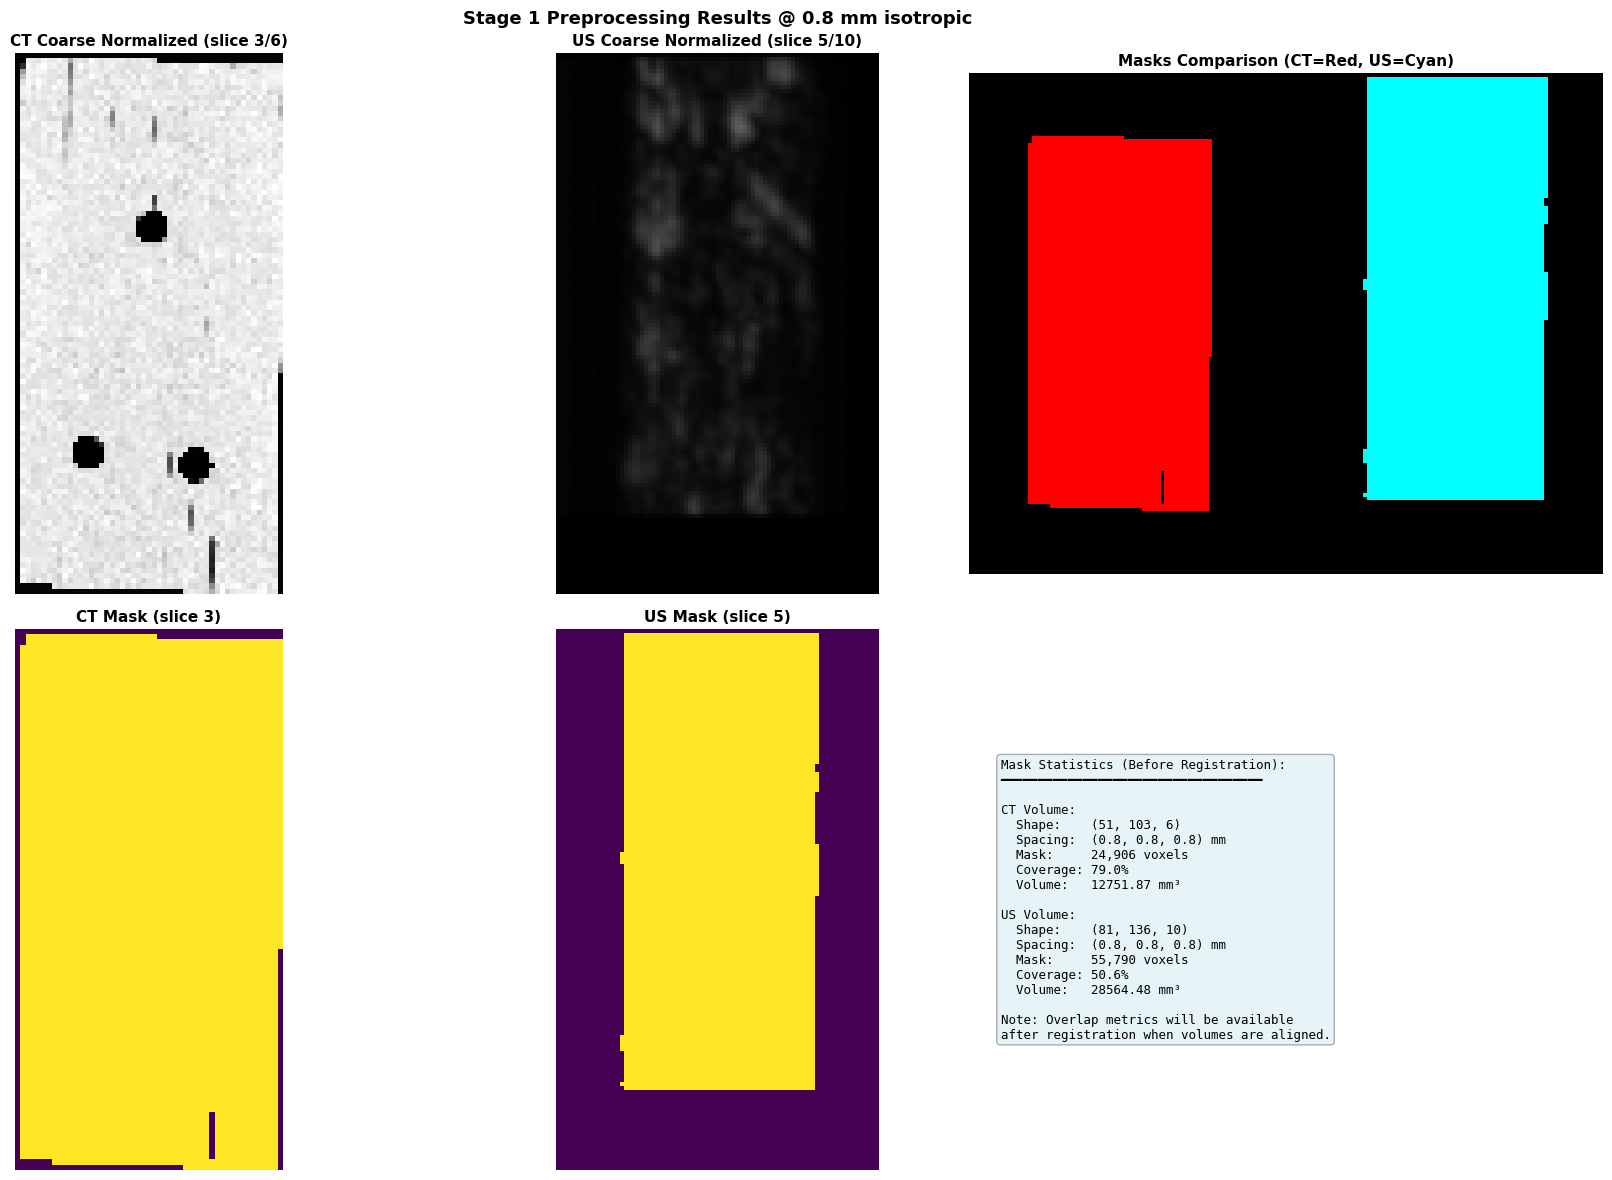


✓ Visualization complete


In [215]:
# VISUALIZATION: Stage 1 Preprocessed Volumes
# ==============================================

print("\n" + "="*70)
print("VISUALIZATION: STAGE 1 PREPROCESSED VOLUMES")
print("="*70)

# Get arrays
ct_coarse_arr = sitk.GetArrayFromImage(ct_coarse_norm)
us_coarse_arr = sitk.GetArrayFromImage(us_coarse_norm)
ct_mask_arr = sitk.GetArrayFromImage(ct_mask_coarse)
us_mask_arr = sitk.GetArrayFromImage(us_mask_coarse)

# Find middle slices for each volume
ct_z_mid = ct_coarse_arr.shape[0] // 2
us_z_mid = us_coarse_arr.shape[0] // 2

# Create visualization with 2x3 layout
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# CT coarse normalized
axes[0, 0].imshow(ct_coarse_arr[ct_z_mid], cmap='gray', vmin=0, vmax=1)
axes[0, 0].set_title(f'CT Coarse Normalized (slice {ct_z_mid}/{ct_coarse_arr.shape[0]})', fontsize=11, weight='bold')
axes[0, 0].set_xlabel(f'Shape: {ct_coarse.GetSize()}, Spacing: {ct_coarse.GetSpacing()} mm', fontsize=9)
axes[0, 0].axis('off')

# US coarse normalized
axes[0, 1].imshow(us_coarse_arr[us_z_mid], cmap='gray', vmin=0, vmax=1)
axes[0, 1].set_title(f'US Coarse Normalized (slice {us_z_mid}/{us_coarse_arr.shape[0]})', fontsize=11, weight='bold')
axes[0, 1].set_xlabel(f'Shape: {us_coarse.GetSize()}, Spacing: {us_coarse.GetSpacing()} mm', fontsize=9)
axes[0, 1].axis('off')

# Both masks side-by-side comparison
# Note: Cannot overlay directly before registration due to different coordinate spaces
# Create side-by-side view with CT mask (left half) and US mask (right half)
max_height = max(ct_mask_arr.shape[1], us_mask_arr.shape[1])
max_width = max(ct_mask_arr.shape[2], us_mask_arr.shape[2])
combined_width = max_width * 2 + 10  # 10 pixel gap

# Create canvas
mask_comparison = np.zeros((max_height, combined_width, 3), dtype=np.float32)

# Place CT mask (red) on left side, centered
ct_slice = ct_mask_arr[ct_z_mid]
ct_h, ct_w = ct_slice.shape
ct_y_offset = (max_height - ct_h) // 2
ct_x_offset = (max_width - ct_w) // 2
mask_comparison[ct_y_offset:ct_y_offset+ct_h, ct_x_offset:ct_x_offset+ct_w, 0] = ct_slice

# Place US mask (cyan) on right side, centered
us_slice = us_mask_arr[us_z_mid]
us_h, us_w = us_slice.shape
us_y_offset = (max_height - us_h) // 2
us_x_offset = max_width + 10 + (max_width - us_w) // 2
mask_comparison[us_y_offset:us_y_offset+us_h, us_x_offset:us_x_offset+us_w, 1:3] = us_slice[:, :, np.newaxis]

axes[0, 2].imshow(mask_comparison)
axes[0, 2].set_title(f'Masks Comparison (CT=Red, US=Cyan)', fontsize=11, weight='bold')
axes[0, 2].set_xlabel(f'Side-by-side view (not aligned yet)', fontsize=9)
axes[0, 2].axis('off')

# CT mask
axes[1, 0].imshow(ct_mask_arr[ct_z_mid], cmap='viridis', vmin=0, vmax=1)
axes[1, 0].set_title(f'CT Mask (slice {ct_z_mid})', fontsize=11, weight='bold')
axes[1, 0].set_xlabel(f'{ct_mask_voxels:,} voxels ({100*ct_mask_voxels/ct_total_voxels:.1f}%)', fontsize=9)
axes[1, 0].axis('off')

# US mask
axes[1, 1].imshow(us_mask_arr[us_z_mid], cmap='viridis', vmin=0, vmax=1)
axes[1, 1].set_title(f'US Mask (slice {us_z_mid})', fontsize=11, weight='bold')
axes[1, 1].set_xlabel(f'{us_mask_voxels:,} voxels ({100*us_mask_voxels/us_total_voxels:.1f}%)', fontsize=9)
axes[1, 1].axis('off')

# Mask statistics panel
axes[1, 2].axis('off')

# Calculate physical volumes
ct_voxel_volume_mm3 = np.prod(ct_coarse.GetSpacing())  # mm^3 per voxel
us_voxel_volume_mm3 = np.prod(us_coarse.GetSpacing())  # mm^3 per voxel
ct_volume_mm3 = ct_mask_voxels * ct_voxel_volume_mm3
us_volume_mm3 = us_mask_voxels * us_voxel_volume_mm3

stats_text = (
    f'Mask Statistics (Before Registration):\n'
    f'━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n'
    f'\n'
    f'CT Volume:\n'
    f'  Shape:    {ct_coarse.GetSize()}\n'
    f'  Spacing:  {ct_coarse.GetSpacing()} mm\n'
    f'  Mask:     {ct_mask_voxels:,} voxels\n'
    f'  Coverage: {100*ct_mask_voxels/ct_total_voxels:.1f}%\n'
    f'  Volume:   {ct_volume_mm3:.2f} mm³\n'
    f'\n'
    f'US Volume:\n'
    f'  Shape:    {us_coarse.GetSize()}\n'
    f'  Spacing:  {us_coarse.GetSpacing()} mm\n'
    f'  Mask:     {us_mask_voxels:,} voxels\n'
    f'  Coverage: {100*us_mask_voxels/us_total_voxels:.1f}%\n'
    f'  Volume:   {us_volume_mm3:.2f} mm³\n'
    f'\n'
    f'Note: Overlap metrics will be available\n'
    f'after registration when volumes are aligned.'
)
axes[1, 2].text(0.05, 0.5, stats_text, fontsize=9, verticalalignment='center',
                family='monospace', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.suptitle(f'Stage 1 Preprocessing Results @ {CONFIG["STAGE1_SPACING_MM"]} mm isotropic', 
             fontsize=13, weight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")


In [217]:
# STEP 3: Stage 1 Registration Setup
# ====================================

print("\n" + "="*70)
print("STEP 3: STAGE 1 REGISTRATION SETUP")
print("="*70)

print("\nSTRATEGY: Full 6-DOF for coarse stage (establishes 3D alignment)")
print("TRANSFORM DIRECTION: Execute(fixed=US, moving=CT) → CT→US transform")

# Initialize registration method
registration_s1 = sitk.ImageRegistrationMethod()

# Setup metric: Mattes Mutual Information
mi_bins = CONFIG['MI_BINS']
sampling_percent = CONFIG['SAMPLING_PERCENT']
seed = CONFIG['RANDOM_SEED']

registration_s1.SetMetricAsMattesMutualInformation(numberOfHistogramBins=mi_bins)
registration_s1.SetMetricSamplingStrategy(registration_s1.RANDOM)
registration_s1.SetMetricSamplingPercentage(sampling_percent, seed=seed)
print(f"  Metric: Mattes MI with {mi_bins} bins, {sampling_percent*100}% sampling")

# Setup optimizer
learning_rate = CONFIG['LEARNING_RATE']
min_step = CONFIG['MIN_STEP_LENGTH']
max_iters = CONFIG['MAX_ITERS_PER_LEVEL']
relaxation = CONFIG['RELAXATION_FACTOR']

registration_s1.SetOptimizerAsRegularStepGradientDescent(
    learningRate=learning_rate,
    minStep=min_step,
    numberOfIterations=max_iters,
    relaxationFactor=relaxation,
    gradientMagnitudeTolerance=1e-4,
    estimateLearningRate=registration_s1.EachIteration,
    maximumStepSizeInPhysicalUnits=learning_rate
)
registration_s1.SetOptimizerScalesFromPhysicalShift()
print(f"  Optimizer: RegularStepGradientDescent")
print(f"    Learning rate: {learning_rate}, Min step: {min_step}")
print(f"    Max iters: {max_iters}, Relaxation: {relaxation}")

# Setup multi-resolution pyramid
shrink_factors = CONFIG['SHRINK_FACTORS']
smoothing_sigmas = CONFIG['SMOOTHING_SIGMAS_MM']

registration_s1.SetShrinkFactorsPerLevel(shrink_factors)
registration_s1.SetSmoothingSigmasPerLevel(smoothing_sigmas)
registration_s1.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
print(f"  Pyramid: {shrink_factors} shrink, {smoothing_sigmas} mm smoothing")

# Setup interpolator
registration_s1.SetInterpolator(sitk.sitkLinear)
print(f"  Interpolator: Linear")

# Initialize transform with MOMENTS
print(f"\nInitializing transform...")
initial_tx_s1 = sitk.Euler3DTransform()

try:
    initial_tx_s1 = sitk.CenteredTransformInitializer(
        us_mask_coarse,
        ct_mask_coarse,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.MOMENTS
    )
    print(f"  Using MOMENTS initialization (with masks)")
except Exception:
    try:
        initial_tx_s1 = sitk.CenteredTransformInitializer(
            us_coarse_norm,
            ct_coarse_norm,
            sitk.Euler3DTransform(),
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
        print(f"  Using GEOMETRY initialization (MOMENTS failed)")
    except Exception:
        print(f"  Using identity transform")

# Apply full 6-DOF (no constraints for Stage 1)
free_dof_s1 = FREE_DOF_FULL_6DOF
constrain_euler3d_params(initial_tx_s1, free_dof_s1)
registration_s1.SetInitialTransform(initial_tx_s1, inPlace=True)

params_init = initial_tx_s1.GetParameters()
print(f"  Initial params: tx={params_init[3]:.2f}, ty={params_init[4]:.2f}, tz={params_init[5]:.2f} mm")

# Set masks
registration_s1.SetMetricFixedMask(us_mask_coarse)
registration_s1.SetMetricMovingMask(ct_mask_coarse)
print(f"  Masks: Applied")

# Setup callbacks
metrics_s1 = []

def metric_callback_s1():
    metrics_s1.append(registration_s1.GetMetricValue())

def multiresolution_callback_s1():
    level = registration_s1.GetCurrentLevel()
    shrink = shrink_factors[level] if level < len(shrink_factors) else 1
    sigma = smoothing_sigmas[level] if level < len(smoothing_sigmas) else 0
    print(f"  → Level {level+1}/{len(shrink_factors)}: shrink={shrink}, sigma={sigma:.1f}mm")

def end_callback_s1():
    print(f"  → Stop: {registration_s1.GetOptimizerStopConditionDescription()}")
    print(f"  → Final MI: {registration_s1.GetMetricValue():.6f}")

constraint_callback_s1 = create_dof_constraint_callback(initial_tx_s1, free_dof_s1, verbose=False)

registration_s1.AddCommand(sitk.sitkIterationEvent, metric_callback_s1)
registration_s1.AddCommand(sitk.sitkIterationEvent, constraint_callback_s1)
registration_s1.AddCommand(sitk.sitkMultiResolutionIterationEvent, multiresolution_callback_s1)
registration_s1.AddCommand(sitk.sitkEndEvent, end_callback_s1)

print("\n✓ Stage 1 registration configured")



STEP 3: STAGE 1 REGISTRATION SETUP

STRATEGY: Full 6-DOF for coarse stage (establishes 3D alignment)
TRANSFORM DIRECTION: Execute(fixed=US, moving=CT) → CT→US transform
  Metric: Mattes MI with 64 bins, 35.0% sampling
  Optimizer: RegularStepGradientDescent
    Learning rate: 2.0, Min step: 1e-06
    Max iters: 1000, Relaxation: 0.5
  Pyramid: [3, 2, 1] shrink, [2.5, 1.5, 0.0] mm smoothing
  Interpolator: Linear

Initializing transform...
  Using MOMENTS initialization (with masks)
  Initial params: tx=-12.32, ty=-5.31, tz=-1.20 mm
  Masks: Applied

✓ Stage 1 registration configured


In [218]:
# STEP 4: Execute Stage 1 Registration
# ======================================

print("\n" + "="*70)
print("STEP 4: EXECUTING STAGE 1 REGISTRATION")
print("="*70)

print(f"\nFixed:  {us_coarse_norm.GetSize()} @ {us_coarse_norm.GetSpacing()} mm")
print(f"Moving: {ct_coarse_norm.GetSize()} @ {ct_coarse_norm.GetSpacing()} mm")
print(f"\nStarting registration...")

# Execute registration
tx_stage1 = registration_s1.Execute(us_coarse_norm, ct_coarse_norm)

# Enforce constraints one more time
constrain_euler3d_params(tx_stage1, free_dof_s1)

# Print final parameters
params_s1 = tx_stage1.GetParameters()
print(f"\n{'='*70}")
print(f"STAGE 1 FINAL TRANSFORM PARAMETERS (CT→US)")
print(f"{'='*70}")
print(f"  Rotation X (rx): {np.rad2deg(params_s1[0]):+10.6f}°")
print(f"  Rotation Y (ry): {np.rad2deg(params_s1[1]):+10.6f}°")
print(f"  Rotation Z (rz): {np.rad2deg(params_s1[2]):+10.6f}°")
print(f"  Translation X:   {params_s1[3]:+10.4f} mm")
print(f"  Translation Y:   {params_s1[4]:+10.4f} mm")
print(f"  Translation Z:   {params_s1[5]:+10.4f} mm")
print(f"{'='*70}")

# Save transform
tx_stage1_path = out_dir / "stage1_rigid_ct_to_us.tfm"
write_transform(tx_stage1, str(tx_stage1_path))

# Save metric log
with open(out_dir / "stage1_metric_log.txt", 'w') as f:
    for i, val in enumerate(metrics_s1):
        f.write(f"{i}\t{val:.6f}\n")
print(f"  ✓ Saved metric log: stage1_metric_log.txt")

print(f"\n✓ Stage 1 registration complete")
print(f"  MI improvement: {metrics_s1[0]:.4f} → {metrics_s1[-1]:.4f} (Δ={metrics_s1[-1]-metrics_s1[0]:+.4f})")
print(f"  Total iterations: {len(metrics_s1)}")



STEP 4: EXECUTING STAGE 1 REGISTRATION

Fixed:  (81, 136, 10) @ (0.8, 0.8, 0.8) mm
Moving: (51, 103, 6) @ (0.8, 0.8, 0.8) mm

Starting registration...
  → Level 1/3: shrink=3, sigma=2.5mm
  → Level 2/3: shrink=2, sigma=1.5mm
  → Level 3/3: shrink=1, sigma=0.0mm
  → Stop: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (1000) exceeded.
  → Final MI: -0.810199

STAGE 1 FINAL TRANSFORM PARAMETERS (CT→US)
  Rotation X (rx):  -1.953818°
  Rotation Y (ry): +10.451179°
  Rotation Z (rz):  +0.288707°
  Translation X:     -11.1096 mm
  Translation Y:      -4.0757 mm
  Translation Z:     -10.5416 mm
  ✓ Saved transform: outputs/registration_stepwise/stage1_rigid_ct_to_us.tfm
  ✓ Saved metric log: stage1_metric_log.txt

✓ Stage 1 registration complete
  MI improvement: -1.1086 → -0.8102 (Δ=+0.2984)
  Total iterations: 1549



QC: STAGE 1 REGISTRATION QUALITY CONTROL

Warping CT to US space using Stage 1 transform...
  Dice coefficient (Stage 1): 0.0063
  US optimal slice: 1/10 (mean of max signal indices)
  CT optimal slice: 10/10 (center of mass of material)


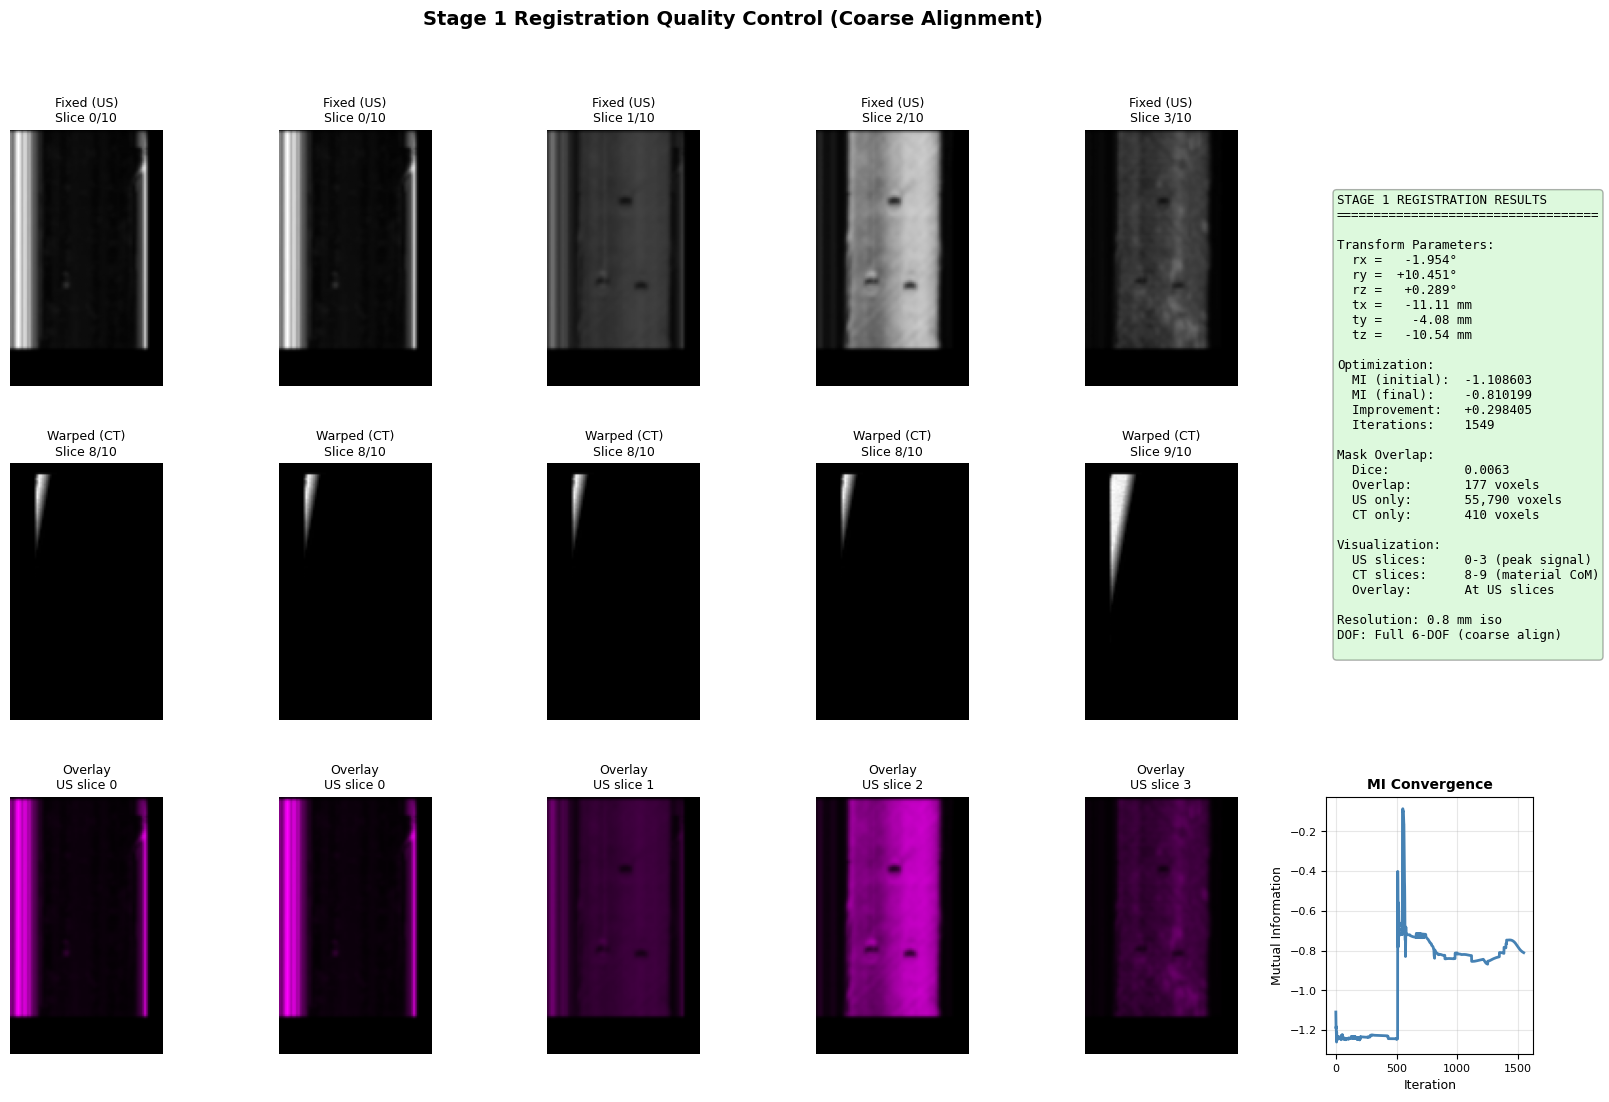


✓ Stage 1 QC complete
  Dice: 0.0063
  Ready to proceed to Stage 2 (fine alignment)


In [219]:
# QC: Stage 1 Registration Quality Control
# ===========================================

print("\n" + "="*70)
print("QC: STAGE 1 REGISTRATION QUALITY CONTROL")
print("="*70)

# Apply Stage 1 transform to warp CT to US space
print("\nWarping CT to US space using Stage 1 transform...")
resampler_qc_s1 = sitk.ResampleImageFilter()
resampler_qc_s1.SetReferenceImage(us_coarse_norm)
resampler_qc_s1.SetTransform(tx_stage1)
resampler_qc_s1.SetInterpolator(sitk.sitkLinear)
ct_warped_s1 = resampler_qc_s1.Execute(ct_coarse_norm)

# Warp CT mask to US space for Dice calculation
resampler_mask_s1 = sitk.ResampleImageFilter()
resampler_mask_s1.SetReferenceImage(us_mask_coarse)
resampler_mask_s1.SetTransform(tx_stage1)
resampler_mask_s1.SetInterpolator(sitk.sitkNearestNeighbor)
ct_mask_warped_s1 = resampler_mask_s1.Execute(ct_mask_coarse)

# Calculate Dice after Stage 1
dice_s1 = dice_coefficient(us_mask_coarse, ct_mask_warped_s1)
print(f"  Dice coefficient (Stage 1): {dice_s1:.4f}")

# Get arrays for visualization
us_s1_arr = sitk.GetArrayFromImage(us_coarse_norm)
ct_warped_s1_arr = sitk.GetArrayFromImage(ct_warped_s1)
us_mask_s1_arr = sitk.GetArrayFromImage(us_mask_coarse)
ct_mask_warped_s1_arr = sitk.GetArrayFromImage(ct_mask_warped_s1)

# Find optimal US slice (mean of max indices - where signal is strongest)
max_indices_s1 = np.argmax(us_s1_arr, axis=0)
optimal_us_slice_s1 = int(np.round(np.mean(max_indices_s1)))
optimal_us_slice_s1 = np.clip(optimal_us_slice_s1, 0, us_s1_arr.shape[0] - 1)
print(f"  US optimal slice: {optimal_us_slice_s1}/{us_s1_arr.shape[0]} (mean of max signal indices)")

# CT: find optimal slice where material is present (using mask center of mass)
optimal_ct_slice_s1 = 10# find_optimal_ct_slice(ct_warped_s1_arr, ct_mask_warped_s1_arr)
print(f"  CT optimal slice: {optimal_ct_slice_s1}/{ct_warped_s1_arr.shape[0]} (center of mass of material)")

# Select slices to visualize: centered around US optimal slice
num_slices = 5
half_range = num_slices // 2
z_start = max(0, optimal_us_slice_s1 - half_range)
z_end = min(us_s1_arr.shape[0] - 1, optimal_us_slice_s1 + half_range)
z_indices_us = np.linspace(z_start, z_end, num_slices, dtype=int)

# CT slices: centered around CT optimal slice
z_start_ct = max(0, optimal_ct_slice_s1 - half_range)
z_end_ct = min(ct_warped_s1_arr.shape[0] - 1, optimal_ct_slice_s1 + half_range)
z_indices_ct = np.linspace(z_start_ct, z_end_ct, num_slices, dtype=int)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, num_slices+1, hspace=0.3, wspace=0.3)

# Row 1: Fixed (US) volume - at US optimal slices
for i, z in enumerate(z_indices_us):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(us_s1_arr[z], cmap='gray', vmin=0, vmax=1)
    ax.set_title(f'Fixed (US)\nSlice {z}/{us_s1_arr.shape[0]}', fontsize=9)
    ax.axis('off')

# Row 2: Warped (CT) volume - at CT middle slices
for i, z in enumerate(z_indices_ct):
    ax = fig.add_subplot(gs[1, i])
    ax.imshow(ct_warped_s1_arr[z], cmap='gray', vmin=0, vmax=1)
    ax.set_title(f'Warped (CT)\nSlice {z}/{ct_warped_s1_arr.shape[0]}', fontsize=9)
    ax.axis('off')

# Row 3: Overlay at US optimal slices (both volumes at same US slice)
for i, z in enumerate(z_indices_us):
    ax = fig.add_subplot(gs[2, i])
    overlay = create_overlay_rgb(us_s1_arr[z], ct_warped_s1_arr[z], alpha=0.5)
    ax.imshow(overlay)
    ax.set_title(f'Overlay\nUS slice {z}', fontsize=9)
    ax.axis('off')

# Right column: Statistics and metrics
ax_stats = fig.add_subplot(gs[0:2, -1])
ax_stats.axis('off')

# Calculate overlap statistics
overlap_voxels_s1 = np.sum(np.logical_and(us_mask_s1_arr, ct_mask_warped_s1_arr))
us_only_voxels_s1 = np.sum(np.logical_and(us_mask_s1_arr, ~ct_mask_warped_s1_arr))
ct_only_voxels_s1 = np.sum(np.logical_and(ct_mask_warped_s1_arr, ~us_mask_s1_arr))

stats_text = (
    f'STAGE 1 REGISTRATION RESULTS\n'
    f'{"="*35}\n\n'
    f'Transform Parameters:\n'
    f'  rx = {np.rad2deg(params_s1[0]):+8.3f}°\n'
    f'  ry = {np.rad2deg(params_s1[1]):+8.3f}°\n'
    f'  rz = {np.rad2deg(params_s1[2]):+8.3f}°\n'
    f'  tx = {params_s1[3]:+8.2f} mm\n'
    f'  ty = {params_s1[4]:+8.2f} mm\n'
    f'  tz = {params_s1[5]:+8.2f} mm\n\n'
    f'Optimization:\n'
    f'  MI (initial):  {metrics_s1[0]:.6f}\n'
    f'  MI (final):    {metrics_s1[-1]:.6f}\n'
    f'  Improvement:   {metrics_s1[-1]-metrics_s1[0]:+.6f}\n'
    f'  Iterations:    {len(metrics_s1)}\n\n'
    f'Mask Overlap:\n'
    f'  Dice:          {dice_s1:.4f}\n'
    f'  Overlap:       {overlap_voxels_s1:,} voxels\n'
    f'  US only:       {us_only_voxels_s1:,} voxels\n'
    f'  CT only:       {ct_only_voxels_s1:,} voxels\n\n'
    f'Visualization:\n'
    f'  US slices:     {int(z_indices_us[0])}-{int(z_indices_us[-1])} (peak signal)\n'
    f'  CT slices:     {int(z_indices_ct[0])}-{int(z_indices_ct[-1])} (material CoM)\n'
    f'  Overlay:       At US slices\n\n'
    f'Resolution: {CONFIG["STAGE1_SPACING_MM"]} mm iso\n'
    f'DOF: Full 6-DOF (coarse align)\n'
)
ax_stats.text(0.05, 0.5, stats_text, fontsize=9, verticalalignment='center',
              family='monospace', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

# Bottom right: MI convergence plot
ax_mi = fig.add_subplot(gs[2, -1])
ax_mi.plot(metrics_s1, linewidth=2, color='steelblue')
ax_mi.set_xlabel('Iteration', fontsize=9)
ax_mi.set_ylabel('Mutual Information', fontsize=9)
ax_mi.set_title('MI Convergence', fontsize=10, weight='bold')
ax_mi.grid(True, alpha=0.3)
ax_mi.tick_params(labelsize=8)

plt.suptitle('Stage 1 Registration Quality Control (Coarse Alignment)', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

print(f"\n✓ Stage 1 QC complete")
print(f"  Dice: {dice_s1:.4f}")
print(f"  Ready to proceed to Stage 2 (fine alignment)")


In [ ]:
# STEP 5: Stage 2 Preprocessing (Fine Resolution)
# =================================================

print("\n" + "="*70)
print("STEP 5: STAGE 2 PREPROCESSING (FINE RESOLUTION)")
print("="*70)

# CT: resample to match US in-plane, keep native Z resolution
fine_ct_spacing = CONFIG['STAGE2_CT_SPACING_MM']
print(f"\nResampling CT to {fine_ct_spacing} mm (match US in-plane, keep native CT Z)...")
ct_fine = resample_to_spacing(ct_raw, fine_ct_spacing, 'linear')
print(f"  CT fine: {ct_fine.GetSize()} @ {ct_fine.GetSpacing()} mm")

# US: keep native or resample
if CONFIG['STAGE2_US_KEEP_NATIVE']:
    print(f"\nKeeping US at native resolution...")
    us_fine = us_raw
else:
    print(f"\nResampling US to {fine_ct_spacing} mm...")
    us_fine = resample_to_spacing(us_raw, fine_ct_spacing, 'linear')
print(f"  US fine: {us_fine.GetSize()} @ {us_fine.GetSpacing()} mm")

# Normalize
print(f"\nNormalizing intensities...")
ct_fine_norm = normalize_ct(ct_fine, CONFIG['CT_CLIP_PERCENTILES'])
print(f"  CT normalized range: [{sitk.GetArrayFromImage(ct_fine_norm).min():.3f}, {sitk.GetArrayFromImage(ct_fine_norm).max():.3f}]")

us_fine_norm = normalize_us(
    us_fine,
    sigma_voxels=CONFIG['US_GAUSSIAN_SIGMA_VOXELS'],
    percentiles=CONFIG['US_CLIP_PERCENTILES'],
    log_compress=CONFIG['US_LOG_COMPRESSION']
)
print(f"  US normalized range: [{sitk.GetArrayFromImage(us_fine_norm).min():.3f}, {sitk.GetArrayFromImage(us_fine_norm).max():.3f}]")

# Create masks
print(f"\nCreating fine masks...")

# CT mask from ORIGINAL resolution (RAW, not normalized), then resample to fine
# Reuse ct_mask_original from Stage 1 if available
if 'ct_mask_original' not in locals():
    print(f"  Creating CT mask at original resolution...")
    ct_mask_original = create_ct_mask_from_original(ct_raw)
else:
    print(f"  Reusing CT mask from Stage 1 preprocessing...")
print(f"  Resampling CT mask to fine resolution...")
ct_mask_fine = resample_mask_to_target(ct_mask_original, ct_fine_norm)

# US mask from ORIGINAL resolution, then resample to fine
# Reuse us_raw_norm and us_mask_original from Stage 1 if available
if 'us_raw_norm' not in locals():
    print(f"  Creating US mask at original resolution...")
    us_raw_norm = normalize_us(
        us_raw,
        sigma_voxels=CONFIG['US_GAUSSIAN_SIGMA_VOXELS'],
        percentiles=CONFIG['US_CLIP_PERCENTILES'],
        log_compress=CONFIG['US_LOG_COMPRESSION']
    )
    us_mask_original = create_us_mask_from_original(us_raw, use_otsu_on_optimal_slice=True)
else:
    print(f"  Reusing US mask from Stage 1 preprocessing...")
print(f"  Resampling US mask to fine resolution...")
us_mask_fine = resample_mask_to_target(us_mask_original, us_fine_norm)

ct_mask_fine_voxels = np.sum(sitk.GetArrayFromImage(ct_mask_fine))
us_mask_fine_voxels = np.sum(sitk.GetArrayFromImage(us_mask_fine))
ct_fine_total_voxels = np.prod(ct_fine_norm.GetSize())
us_fine_total_voxels = np.prod(us_fine_norm.GetSize())

print(f"  CT fine mask: {ct_mask_fine_voxels:,} voxels ({100*ct_mask_fine_voxels/ct_fine_total_voxels:.1f}% of volume)")
print(f"  US fine mask: {us_mask_fine_voxels:,} voxels ({100*us_mask_fine_voxels/us_fine_total_voxels:.1f}% of volume)")

print("\n✓ Stage 2 preprocessing complete")



STEP 5: STAGE 2 PREPROCESSING (FINE RESOLUTION)

Resampling CT to 0.5 mm isotropic...
  CT fine: (81, 164, 10) @ (0.5, 0.5, 0.5) mm

Keeping US at native resolution...
  US fine: (65, 109, 500) @ (1.0, 1.0, 0.016) mm

Normalizing intensities...
  CT normalized range: [0.000, 1.000]
  US normalized range: [0.000, 1.000]

Creating fine masks...
  Reusing CT mask from Stage 1 preprocessing...
  Resampling CT mask to fine resolution...
  Reusing US mask from Stage 1 preprocessing...
  Resampling US mask to fine resolution...
  CT fine mask: 106,546 voxels (80.2% of volume)
  US fine mask: 1,771,500 voxels (50.0% of volume)

✓ Stage 2 preprocessing complete


In [221]:
# STEP 6: Stage 2 Registration Setup
# ====================================

print("\n" + "="*70)
print("STEP 6: STAGE 2 REGISTRATION SETUP")
print("="*70)

print("\nSTRATEGY: In-plane constraints (tx, ty, rz) applied in fine stage")
print("Initializing from Stage 1 transform...")

# Initialize registration method
registration_s2 = sitk.ImageRegistrationMethod()

# Setup metric
registration_s2.SetMetricAsMattesMutualInformation(numberOfHistogramBins=mi_bins)
registration_s2.SetMetricSamplingStrategy(registration_s2.RANDOM)
registration_s2.SetMetricSamplingPercentage(sampling_percent, seed=seed)
print(f"  Metric: Mattes MI with {mi_bins} bins")

# Setup optimizer with smaller learning rate for fine stage
lr_s2 = learning_rate * 0.5
min_step_s2 = min_step * 0.5

registration_s2.SetOptimizerAsRegularStepGradientDescent(
    learningRate=lr_s2,
    minStep=min_step_s2,
    numberOfIterations=max_iters,
    relaxationFactor=relaxation,
    gradientMagnitudeTolerance=1e-4,
    estimateLearningRate=registration_s2.EachIteration,
    maximumStepSizeInPhysicalUnits=lr_s2
)
registration_s2.SetOptimizerScalesFromPhysicalShift()
print(f"  Optimizer: RegularStepGradientDescent (LR={lr_s2}, min_step={min_step_s2})")

# Setup finer pyramid for Stage 2
shrink_factors_s2 = [4, 2, 1]
smoothing_sigmas_s2 = [2.0, 1.0, 0.0]

registration_s2.SetShrinkFactorsPerLevel(shrink_factors_s2)
registration_s2.SetSmoothingSigmasPerLevel(smoothing_sigmas_s2)
registration_s2.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
print(f"  Pyramid: {shrink_factors_s2} shrink, {smoothing_sigmas_s2} mm smoothing")

# Setup interpolator
registration_s2.SetInterpolator(sitk.sitkLinear)

# Initialize from Stage 1 result
initial_tx_s2 = sitk.Euler3DTransform(tx_stage1)

# Apply in-plane constraints
free_dof_s2 = FREE_DOF_INPLANE_RZ if CONFIG['ALLOW_RZ'] else FREE_DOF_INPLANE_NO_RZ
constrain_euler3d_params(initial_tx_s2, free_dof_s2)
registration_s2.SetInitialTransform(initial_tx_s2, inPlace=True)

print(f"  DOF constraints: {free_dof_s2}")
print(f"    rx={'✓' if free_dof_s2[0] else '✗'} ry={'✓' if free_dof_s2[1] else '✗'} "
      f"rz={'✓' if free_dof_s2[2] else '✗'} tx={'✓' if free_dof_s2[3] else '✗'} "
      f"ty={'✓' if free_dof_s2[4] else '✗'} tz={'✓' if free_dof_s2[5] else '✗'}")

# Set masks
registration_s2.SetMetricFixedMask(us_mask_fine)
registration_s2.SetMetricMovingMask(ct_mask_fine)

# Setup callbacks
metrics_s2 = []

def metric_callback_s2():
    metrics_s2.append(registration_s2.GetMetricValue())

def multiresolution_callback_s2():
    level = registration_s2.GetCurrentLevel()
    shrink = shrink_factors_s2[level] if level < len(shrink_factors_s2) else 1
    sigma = smoothing_sigmas_s2[level] if level < len(smoothing_sigmas_s2) else 0
    print(f"  → Level {level+1}/{len(shrink_factors_s2)}: shrink={shrink}, sigma={sigma:.1f}mm")

def end_callback_s2():
    print(f"  → Stop: {registration_s2.GetOptimizerStopConditionDescription()}")
    print(f"  → Final MI: {registration_s2.GetMetricValue():.6f}")

constraint_callback_s2 = create_dof_constraint_callback(initial_tx_s2, free_dof_s2, verbose=False)

registration_s2.AddCommand(sitk.sitkIterationEvent, metric_callback_s2)
registration_s2.AddCommand(sitk.sitkIterationEvent, constraint_callback_s2)
registration_s2.AddCommand(sitk.sitkMultiResolutionIterationEvent, multiresolution_callback_s2)
registration_s2.AddCommand(sitk.sitkEndEvent, end_callback_s2)

print("\n✓ Stage 2 registration configured")



STEP 6: STAGE 2 REGISTRATION SETUP

STRATEGY: In-plane constraints (tx, ty, rz) applied in fine stage
Initializing from Stage 1 transform...
  Metric: Mattes MI with 64 bins
  Optimizer: RegularStepGradientDescent (LR=1.0, min_step=5e-07)
  Pyramid: [4, 2, 1] shrink, [2.0, 1.0, 0.0] mm smoothing
  DOF constraints: (False, False, True, True, True, False)
    rx=✗ ry=✗ rz=✓ tx=✓ ty=✓ tz=✗

✓ Stage 2 registration configured


In [222]:
# STEP 7: Execute Stage 2 Registration
# ======================================

print("\n" + "="*70)
print("STEP 7: EXECUTING STAGE 2 REGISTRATION")
print("="*70)

print(f"\nFixed:  {us_fine_norm.GetSize()} @ {us_fine_norm.GetSpacing()} mm")
print(f"Moving: {ct_fine_norm.GetSize()} @ {ct_fine_norm.GetSpacing()} mm")
print(f"\nStarting registration...")

# Execute registration
tx_stage2 = registration_s2.Execute(us_fine_norm, ct_fine_norm)

# Enforce constraints one more time
constrain_euler3d_params(tx_stage2, free_dof_s2)

# Print final parameters
params_s2 = tx_stage2.GetParameters()
print(f"\n{'='*70}")
print(f"STAGE 2 FINAL TRANSFORM PARAMETERS (CT→US)")
print(f"{'='*70}")
print(f"  Rotation X (rx): {np.rad2deg(params_s2[0]):+10.6f}° {'[LOCKED]' if not free_dof_s2[0] else ''}")
print(f"  Rotation Y (ry): {np.rad2deg(params_s2[1]):+10.6f}° {'[LOCKED]' if not free_dof_s2[1] else ''}")
print(f"  Rotation Z (rz): {np.rad2deg(params_s2[2]):+10.6f}° {'[LOCKED]' if not free_dof_s2[2] else ''}")
print(f"  Translation X:   {params_s2[3]:+10.4f} mm {'[LOCKED]' if not free_dof_s2[3] else ''}")
print(f"  Translation Y:   {params_s2[4]:+10.4f} mm {'[LOCKED]' if not free_dof_s2[4] else ''}")
print(f"  Translation Z:   {params_s2[5]:+10.4f} mm {'[LOCKED]' if not free_dof_s2[5] else ''}")
print(f"{'='*70}")

# Show refinement from Stage 1 to Stage 2
print(f"\nSTAGE 1 → STAGE 2 REFINEMENT:")
print(f"  Δtx: {params_s2[3] - params_s1[3]:+.2f} mm")
print(f"  Δty: {params_s2[4] - params_s1[4]:+.2f} mm")
print(f"  Δtz: {params_s2[5] - params_s1[5]:+.2f} mm (should be ~0 if in-plane constraint worked)")
print(f"  Δrz: {np.rad2deg(params_s2[2] - params_s1[2]):+.2f}°")

# Save transform
tx_stage2_path = out_dir / "stage2_rigid_ct_to_us.tfm"
write_transform(tx_stage2, str(tx_stage2_path))

# Save metric log
with open(out_dir / "stage2_metric_log.txt", 'w') as f:
    for i, val in enumerate(metrics_s2):
        f.write(f"{i}\t{val:.6f}\n")
print(f"  ✓ Saved metric log: stage2_metric_log.txt")

print(f"\n✓ Stage 2 registration complete")
print(f"  MI improvement: {metrics_s2[0]:.4f} → {metrics_s2[-1]:.4f} (Δ={metrics_s2[-1]-metrics_s2[0]:+.4f})")
print(f"  Total iterations: {len(metrics_s2)}")



STEP 7: EXECUTING STAGE 2 REGISTRATION

Fixed:  (65, 109, 500) @ (1.0, 1.0, 0.016) mm
Moving: (81, 164, 10) @ (0.5, 0.5, 0.5) mm

Starting registration...
  → Level 1/3: shrink=4, sigma=2.0mm
  → Level 2/3: shrink=2, sigma=1.0mm
  → Level 3/3: shrink=1, sigma=0.0mm
  → Stop: RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 449 iterations. Gradient magnitude (9.29016e-05) is less than gradient magnitude tolerance (0.0001).
  → Final MI: -0.138616

STAGE 2 FINAL TRANSFORM PARAMETERS (CT→US)
  Rotation X (rx):  +0.000000° [LOCKED]
  Rotation Y (ry):  +0.000000° [LOCKED]
  Rotation Z (rz):  +0.368917° 
  Translation X:     -13.9819 mm 
  Translation Y:      -3.2637 mm 
  Translation Z:      +0.0000 mm [LOCKED]

STAGE 1 → STAGE 2 REFINEMENT:
  Δtx: -2.87 mm
  Δty: +0.81 mm
  Δtz: +10.54 mm (should be ~0 if in-plane constraint worked)
  Δrz: +0.08°
  ✓ Saved transform: outputs/registration_stepwise/stage2_rigid_ct_to_us.tfm
  ✓ Saved metric log: stage2_metric_lo


QC: STAGE 2 REGISTRATION QUALITY CONTROL

Warping CT to US space using Stage 2 transform...
  Dice coefficient (Stage 2): 0.6080
  Dice improvement: 0.0063 → 0.6080 (Δ=+0.6017)
  US optimal slice: 74/500 (mean of max signal indices)
  CT optimal slice: 147/500 (center of mass of material)


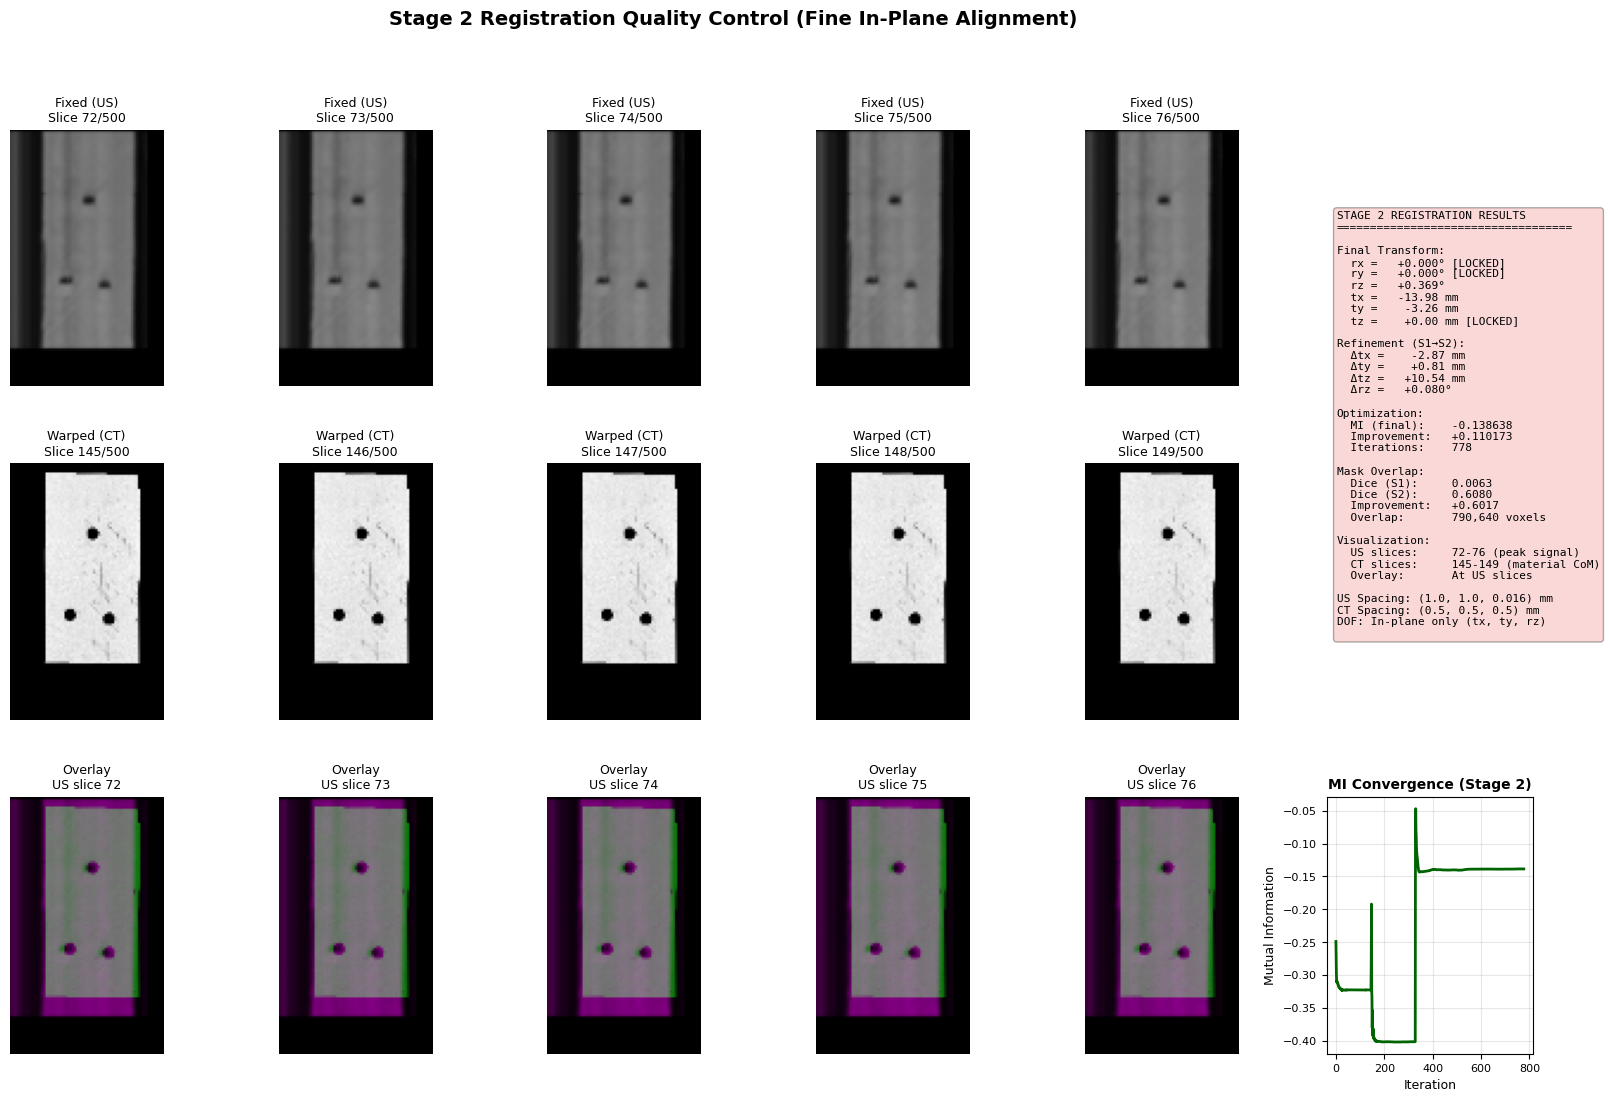


✓ Stage 2 QC complete
  Dice: 0.6080
  Registration pipeline complete!


In [223]:
# QC: Stage 2 Registration Quality Control
# ===========================================

print("\n" + "="*70)
print("QC: STAGE 2 REGISTRATION QUALITY CONTROL")
print("="*70)

# Apply Stage 2 transform to warp CT to US space (at fine resolution)
print("\nWarping CT to US space using Stage 2 transform...")
resampler_qc_s2 = sitk.ResampleImageFilter()
resampler_qc_s2.SetReferenceImage(us_fine_norm)
resampler_qc_s2.SetTransform(tx_stage2)
resampler_qc_s2.SetInterpolator(sitk.sitkLinear)
ct_warped_s2 = resampler_qc_s2.Execute(ct_fine_norm)

# Warp CT mask to US space for Dice calculation
resampler_mask_s2 = sitk.ResampleImageFilter()
resampler_mask_s2.SetReferenceImage(us_mask_fine)
resampler_mask_s2.SetTransform(tx_stage2)
resampler_mask_s2.SetInterpolator(sitk.sitkNearestNeighbor)
ct_mask_warped_s2 = resampler_mask_s2.Execute(ct_mask_fine)

# Calculate Dice after Stage 2
dice_s2 = dice_coefficient(us_mask_fine, ct_mask_warped_s2)
print(f"  Dice coefficient (Stage 2): {dice_s2:.4f}")
print(f"  Dice improvement: {dice_s1:.4f} → {dice_s2:.4f} (Δ={dice_s2-dice_s1:+.4f})")

# Get arrays for visualization
us_s2_arr = sitk.GetArrayFromImage(us_fine_norm)
ct_warped_s2_arr = sitk.GetArrayFromImage(ct_warped_s2)
us_mask_s2_arr = sitk.GetArrayFromImage(us_mask_fine)
ct_mask_warped_s2_arr = sitk.GetArrayFromImage(ct_mask_warped_s2)

# Find optimal US slice (mean of max indices - where signal is strongest)
max_indices_s2 = np.argmax(us_s2_arr, axis=0)
optimal_us_slice_s2 = int(np.round(np.mean(max_indices_s2)))
optimal_us_slice_s2 = np.clip(optimal_us_slice_s2, 0, us_s2_arr.shape[0] - 1)
print(f"  US optimal slice: {optimal_us_slice_s2}/{us_s2_arr.shape[0]} (mean of max signal indices)")

# CT: find optimal slice where material is present (using mask center of mass)
optimal_ct_slice_s2 = find_optimal_ct_slice(ct_warped_s2_arr, ct_mask_warped_s2_arr)
print(f"  CT optimal slice: {optimal_ct_slice_s2}/{ct_warped_s2_arr.shape[0]} (center of mass of material)")

# Select slices to visualize: centered around US optimal slice
num_slices = 5
half_range = num_slices // 2
z_start_s2 = max(0, optimal_us_slice_s2 - half_range)
z_end_s2 = min(us_s2_arr.shape[0] - 1, optimal_us_slice_s2 + half_range)
z_indices_us_s2 = np.linspace(z_start_s2, z_end_s2, num_slices, dtype=int)

# CT slices: centered around CT optimal slice
z_start_ct_s2 = max(0, optimal_ct_slice_s2 - half_range)
z_end_ct_s2 = min(ct_warped_s2_arr.shape[0] - 1, optimal_ct_slice_s2 + half_range)
z_indices_ct_s2 = np.linspace(z_start_ct_s2, z_end_ct_s2, num_slices, dtype=int)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, num_slices+1, hspace=0.3, wspace=0.3)

# Row 1: Fixed (US) volume - at US optimal slices
for i, z in enumerate(z_indices_us_s2):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(us_s2_arr[z], cmap='gray', vmin=0, vmax=1)
    ax.set_title(f'Fixed (US)\nSlice {z}/{us_s2_arr.shape[0]}', fontsize=9)
    ax.axis('off')

# Row 2: Warped (CT) volume - at CT middle slices
for i, z in enumerate(z_indices_ct_s2):
    ax = fig.add_subplot(gs[1, i])
    ax.imshow(ct_warped_s2_arr[z], cmap='gray', vmin=0, vmax=1)
    ax.set_title(f'Warped (CT)\nSlice {z}/{ct_warped_s2_arr.shape[0]}', fontsize=9)
    ax.axis('off')

# Row 3: Overlay at US optimal slices (both volumes at same US slice)
for i, z in enumerate(z_indices_us_s2):
    ax = fig.add_subplot(gs[2, i])
    overlay = create_overlay_rgb(us_s2_arr[z], ct_warped_s2_arr[z], alpha=0.5)
    ax.imshow(overlay)
    ax.set_title(f'Overlay\nUS slice {z}', fontsize=9)
    ax.axis('off')

# Right column: Statistics and metrics
ax_stats = fig.add_subplot(gs[0:2, -1])
ax_stats.axis('off')

# Calculate overlap statistics
overlap_voxels_s2 = np.sum(np.logical_and(us_mask_s2_arr, ct_mask_warped_s2_arr))
us_only_voxels_s2 = np.sum(np.logical_and(us_mask_s2_arr, ~ct_mask_warped_s2_arr))
ct_only_voxels_s2 = np.sum(np.logical_and(ct_mask_warped_s2_arr, ~us_mask_s2_arr))

stats_text = (
    f'STAGE 2 REGISTRATION RESULTS\n'
    f'{"="*35}\n\n'
    f'Final Transform:\n'
    f'  rx = {np.rad2deg(params_s2[0]):+8.3f}° {"[LOCKED]" if not free_dof_s2[0] else ""}\n'
    f'  ry = {np.rad2deg(params_s2[1]):+8.3f}° {"[LOCKED]" if not free_dof_s2[1] else ""}\n'
    f'  rz = {np.rad2deg(params_s2[2]):+8.3f}° {"[LOCKED]" if not free_dof_s2[2] else ""}\n'
    f'  tx = {params_s2[3]:+8.2f} mm\n'
    f'  ty = {params_s2[4]:+8.2f} mm\n'
    f'  tz = {params_s2[5]:+8.2f} mm {"[LOCKED]" if not free_dof_s2[5] else ""}\n\n'
    f'Refinement (S1→S2):\n'
    f'  Δtx = {params_s2[3] - params_s1[3]:+8.2f} mm\n'
    f'  Δty = {params_s2[4] - params_s1[4]:+8.2f} mm\n'
    f'  Δtz = {params_s2[5] - params_s1[5]:+8.2f} mm\n'
    f'  Δrz = {np.rad2deg(params_s2[2] - params_s1[2]):+8.3f}°\n\n'
    f'Optimization:\n'
    f'  MI (final):    {metrics_s2[-1]:.6f}\n'
    f'  Improvement:   {metrics_s2[-1]-metrics_s2[0]:+.6f}\n'
    f'  Iterations:    {len(metrics_s2)}\n\n'
    f'Mask Overlap:\n'
    f'  Dice (S1):     {dice_s1:.4f}\n'
    f'  Dice (S2):     {dice_s2:.4f}\n'
    f'  Improvement:   {dice_s2-dice_s1:+.4f}\n'
    f'  Overlap:       {overlap_voxels_s2:,} voxels\n\n'
    f'Visualization:\n'
    f'  US slices:     {int(z_indices_us_s2[0])}-{int(z_indices_us_s2[-1])} (peak signal)\n'
    f'  CT slices:     {int(z_indices_ct_s2[0])}-{int(z_indices_ct_s2[-1])} (material CoM)\n'
    f'  Overlay:       At US slices\n\n'
    f'US Spacing: {us_fine.GetSpacing()} mm\n'
    f'CT Spacing: {ct_fine.GetSpacing()} mm\n'
    f'DOF: In-plane only (tx, ty, rz)\n'
)
ax_stats.text(0.05, 0.5, stats_text, fontsize=8, verticalalignment='center',
              family='monospace', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))

# Bottom right: MI convergence plot
ax_mi = fig.add_subplot(gs[2, -1])
ax_mi.plot(metrics_s2, linewidth=2, color='darkgreen')
ax_mi.set_xlabel('Iteration', fontsize=9)
ax_mi.set_ylabel('Mutual Information', fontsize=9)
ax_mi.set_title('MI Convergence (Stage 2)', fontsize=10, weight='bold')
ax_mi.grid(True, alpha=0.3)
ax_mi.tick_params(labelsize=8)

plt.suptitle('Stage 2 Registration Quality Control (Fine In-Plane Alignment)', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

print(f"\n✓ Stage 2 QC complete")
print(f"  Dice: {dice_s2:.4f}")
print(f"  Registration pipeline complete!")


In [224]:
# STEP 8: Compute Inverse Transform (US→CT)
# ===========================================

print("\n" + "="*70)
print("STEP 8: COMPUTING INVERSE TRANSFORM (US→CT)")
print("="*70)

try:
    tx_stage2_inv = tx_stage2.GetInverse()
    tx_stage2_inv_path = out_dir / "stage2_rigid_us_to_ct_INVERSE.tfm"
    write_transform(tx_stage2_inv, str(tx_stage2_inv_path))
    has_inverse = True
    print("✓ Inverse transform computed successfully")
except Exception as e:
    print(f"⚠️  Could not compute inverse: {e}")
    tx_stage2_inv = None
    has_inverse = False



STEP 8: COMPUTING INVERSE TRANSFORM (US→CT)
  ✓ Saved transform: outputs/registration_stepwise/stage2_rigid_us_to_ct_INVERSE.tfm
✓ Inverse transform computed successfully


In [225]:
# STEP 9: Export CT into US Space
# =================================

print("\n" + "="*70)
print("STEP 9: EXPORTING CT INTO US SPACE")
print("="*70)

# Create resampler
resampler_export = sitk.ResampleImageFilter()
resampler_export.SetReferenceImage(us_fine_norm)
resampler_export.SetTransform(tx_stage2)
resampler_export.SetInterpolator(sitk.sitkBSpline)

# Export normalized CT→US (for visualization)
print("\nWarping CT to US space (normalized)...")
ct_in_us_norm = resampler_export.Execute(ct_fine_norm)
write_volume(ct_in_us_norm, str(out_dir / "ct_in_us_space_NORMALIZED.tif"))

# Export raw CT→US (preserving intensities)
print("\nWarping CT to US space (raw)...")
ct_in_us_raw = resampler_export.Execute(ct_fine)
write_volume(ct_in_us_raw, str(out_dir / "ct_in_us_space_RAW.tif"))

print("\n✓ CT exported to US space")



STEP 9: EXPORTING CT INTO US SPACE

Warping CT to US space (normalized)...
  ✓ Saved: outputs/registration_stepwise/ct_in_us_space_NORMALIZED.tif

Warping CT to US space (raw)...
  ✓ Saved: outputs/registration_stepwise/ct_in_us_space_RAW.tif

✓ CT exported to US space


In [226]:
# STEP 10: Compute Dice Validation
# ==================================

print("\n" + "="*70)
print("STEP 10: COMPUTING DICE SCORES")
print("="*70)

# Dice in CT space (US→CT via inverse)
if has_inverse:
    print("\nWarping US mask to CT space...")
    resampler_ct = sitk.ResampleImageFilter()
    resampler_ct.SetReferenceImage(ct_fine_norm)
    resampler_ct.SetTransform(tx_stage2_inv)
    resampler_ct.SetInterpolator(sitk.sitkNearestNeighbor)
    us_mask_in_ct = resampler_ct.Execute(us_mask_fine)
    write_volume(us_mask_in_ct, str(out_dir / "us_mask_in_ct_space.tif"))
    
    dice_ct_space = dice_coefficient(ct_mask_fine, us_mask_in_ct)
    print(f"  Dice (CT space): {dice_ct_space:.4f}")
else:
    dice_ct_space = None
    print(f"  Dice (CT space): N/A (no inverse)")

# Dice in US space (CT→US via tx_stage2)
print("\nWarping CT mask to US space...")
resampler_us = sitk.ResampleImageFilter()
resampler_us.SetReferenceImage(us_fine_norm)
resampler_us.SetTransform(tx_stage2)
resampler_us.SetInterpolator(sitk.sitkNearestNeighbor)
ct_mask_in_us = resampler_us.Execute(ct_mask_fine)
write_volume(ct_mask_in_us, str(out_dir / "ct_mask_in_us_space.tif"))

dice_us_space = dice_coefficient(us_mask_fine, ct_mask_in_us)
print(f"  Dice (US space): {dice_us_space:.4f}")

# Save Dice scores
dice_scores = {
    'dice_ct_space': float(dice_ct_space) if dice_ct_space is not None else None,
    'dice_us_space': float(dice_us_space),
}

with open(out_dir / "dice_scores.json", 'w') as f:
    json.dump(dice_scores, f, indent=2)
print(f"\n  ✓ Saved: dice_scores.json")

print("\n✓ Validation complete")



STEP 10: COMPUTING DICE SCORES

Warping US mask to CT space...
  ✓ Saved: outputs/registration_stepwise/us_mask_in_ct_space.tif
  Dice (CT space): 0.8746

Warping CT mask to US space...
  ✓ Saved: outputs/registration_stepwise/ct_mask_in_us_space.tif
  Dice (US space): 0.6080

  ✓ Saved: dice_scores.json

✓ Validation complete


In [227]:
# STEP 11: Save Summary Report
# ==============================

print("\n" + "="*70)
print("STEP 11: SAVING SUMMARY REPORT")
print("="*70)

# Create comprehensive report
with open(out_dir / "registration_report.txt", 'w') as f:
    f.write("="*70 + "\n")
    f.write("2-STAGE IN-PLANE RIGID REGISTRATION REPORT\n")
    f.write("="*70 + "\n\n")
    f.write(f"CT Path: {CONFIG['CT_PATH']}\n")
    f.write(f"US Path: {CONFIG['US_PATH']}\n")
    f.write(f"Output: {CONFIG['OUTPUT_DIR']}\n\n")
    f.write(f"Stage 1 Final MI: {metrics_s1[-1]:.6f}\n")
    f.write(f"Stage 2 Final MI: {metrics_s2[-1]:.6f}\n\n")
    f.write(f"Dice (CT space): {dice_ct_space if dice_ct_space else 'N/A'}\n")
    f.write(f"Dice (US space): {dice_us_space:.4f}\n")
    f.write("="*70 + "\n")

print(f"  ✓ Saved: registration_report.txt")

# Print final summary
print("\n" + "="*70)
print("✓ REGISTRATION PIPELINE COMPLETE")
print("="*70)

print(f"\n{'STAGE 1 (COARSE)':^70}")
print("-"*70)
print(f"  Final MI: {metrics_s1[-1]:.6f}")
print(f"  Iterations: {len(metrics_s1)}")
print(f"  MI improvement: {metrics_s1[-1] - metrics_s1[0]:+.4f}")

print(f"\n{'STAGE 2 (FINE)':^70}")
print("-"*70)
print(f"  Final MI: {metrics_s2[-1]:.6f}")
print(f"  Iterations: {len(metrics_s2)}")
print(f"  MI improvement: {metrics_s2[-1] - metrics_s2[0]:+.4f}")

print(f"\n{'VALIDATION (DICE)':^70}")
print("-"*70)
if dice_ct_space is not None:
    print(f"  CT space: {dice_ct_space:.4f}")
else:
    print(f"  CT space: N/A")
print(f"  US space: {dice_us_space:.4f}")

print(f"\n{'OUTPUTS':^70}")
print("-"*70)
print(f"  Directory: {out_dir}")
print(f"  Transform files:")
print(f"    - stage1_rigid_ct_to_us.tfm")
print(f"    - stage2_rigid_ct_to_us.tfm")
if has_inverse:
    print(f"    - stage2_rigid_us_to_ct_INVERSE.tfm")
print(f"  Warped volumes:")
print(f"    - ct_in_us_space_NORMALIZED.tif")
print(f"    - ct_in_us_space_RAW.tif")
print(f"  Masks:")
print(f"    - ct_mask_in_us_space.tif")
if has_inverse:
    print(f"    - us_mask_in_ct_space.tif")
print(f"  Logs:")
print(f"    - stage1_metric_log.txt")
print(f"    - stage2_metric_log.txt")
print(f"    - dice_scores.json")
print(f"    - registration_report.txt")

print("\n" + "="*70)
print("Next steps: Run visualization cells below for QC")
print("="*70)



STEP 11: SAVING SUMMARY REPORT
  ✓ Saved: registration_report.txt

✓ REGISTRATION PIPELINE COMPLETE

                           STAGE 1 (COARSE)                           
----------------------------------------------------------------------
  Final MI: -0.810199
  Iterations: 1549
  MI improvement: +0.2984

                            STAGE 2 (FINE)                            
----------------------------------------------------------------------
  Final MI: -0.138638
  Iterations: 778
  MI improvement: +0.1102

                          VALIDATION (DICE)                           
----------------------------------------------------------------------
  CT space: 0.8746
  US space: 0.6080

                               OUTPUTS                                
----------------------------------------------------------------------
  Directory: outputs/registration_stepwise
  Transform files:
    - stage1_rigid_ct_to_us.tfm
    - stage2_rigid_ct_to_us.tfm
    - stage2_rigid_us_to_ct_IN

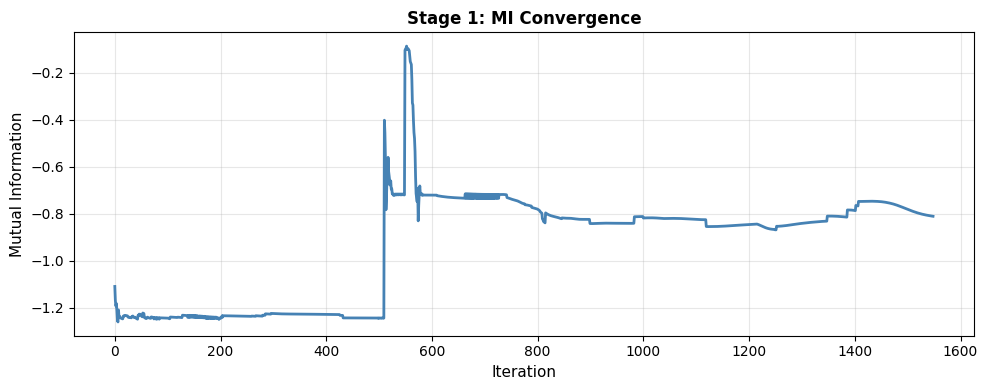

Stage 1: -1.108603 → -0.810199 (improvement: +0.298405)


In [228]:
# QC: Visualize Stage 1 Convergence
# ===================================

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(metrics_s1, linewidth=2, color='steelblue')
ax.set_xlabel('Iteration', fontsize=11)
ax.set_ylabel('Mutual Information', fontsize=11)
ax.set_title('Stage 1: MI Convergence', fontsize=12, weight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Stage 1: {metrics_s1[0]:.6f} → {metrics_s1[-1]:.6f} (improvement: {metrics_s1[-1] - metrics_s1[0]:+.6f})")


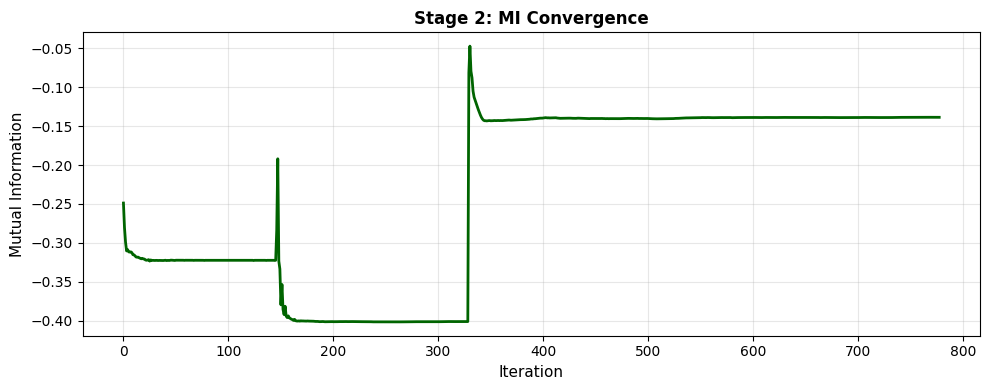

Stage 2: -0.248811 → -0.138638 (improvement: +0.110173)


In [229]:
# QC: Visualize Stage 2 Convergence
# ===================================

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(metrics_s2, linewidth=2, color='darkgreen')
ax.set_xlabel('Iteration', fontsize=11)
ax.set_ylabel('Mutual Information', fontsize=11)
ax.set_title('Stage 2: MI Convergence', fontsize=12, weight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Stage 2: {metrics_s2[0]:.6f} → {metrics_s2[-1]:.6f} (improvement: {metrics_s2[-1] - metrics_s2[0]:+.6f})")



FINAL QC: Best Slice Visualization
  US optimal slice: 74/500 (mean of max signal indices)
  CT optimal slice: 147/500 (center of mass of material)


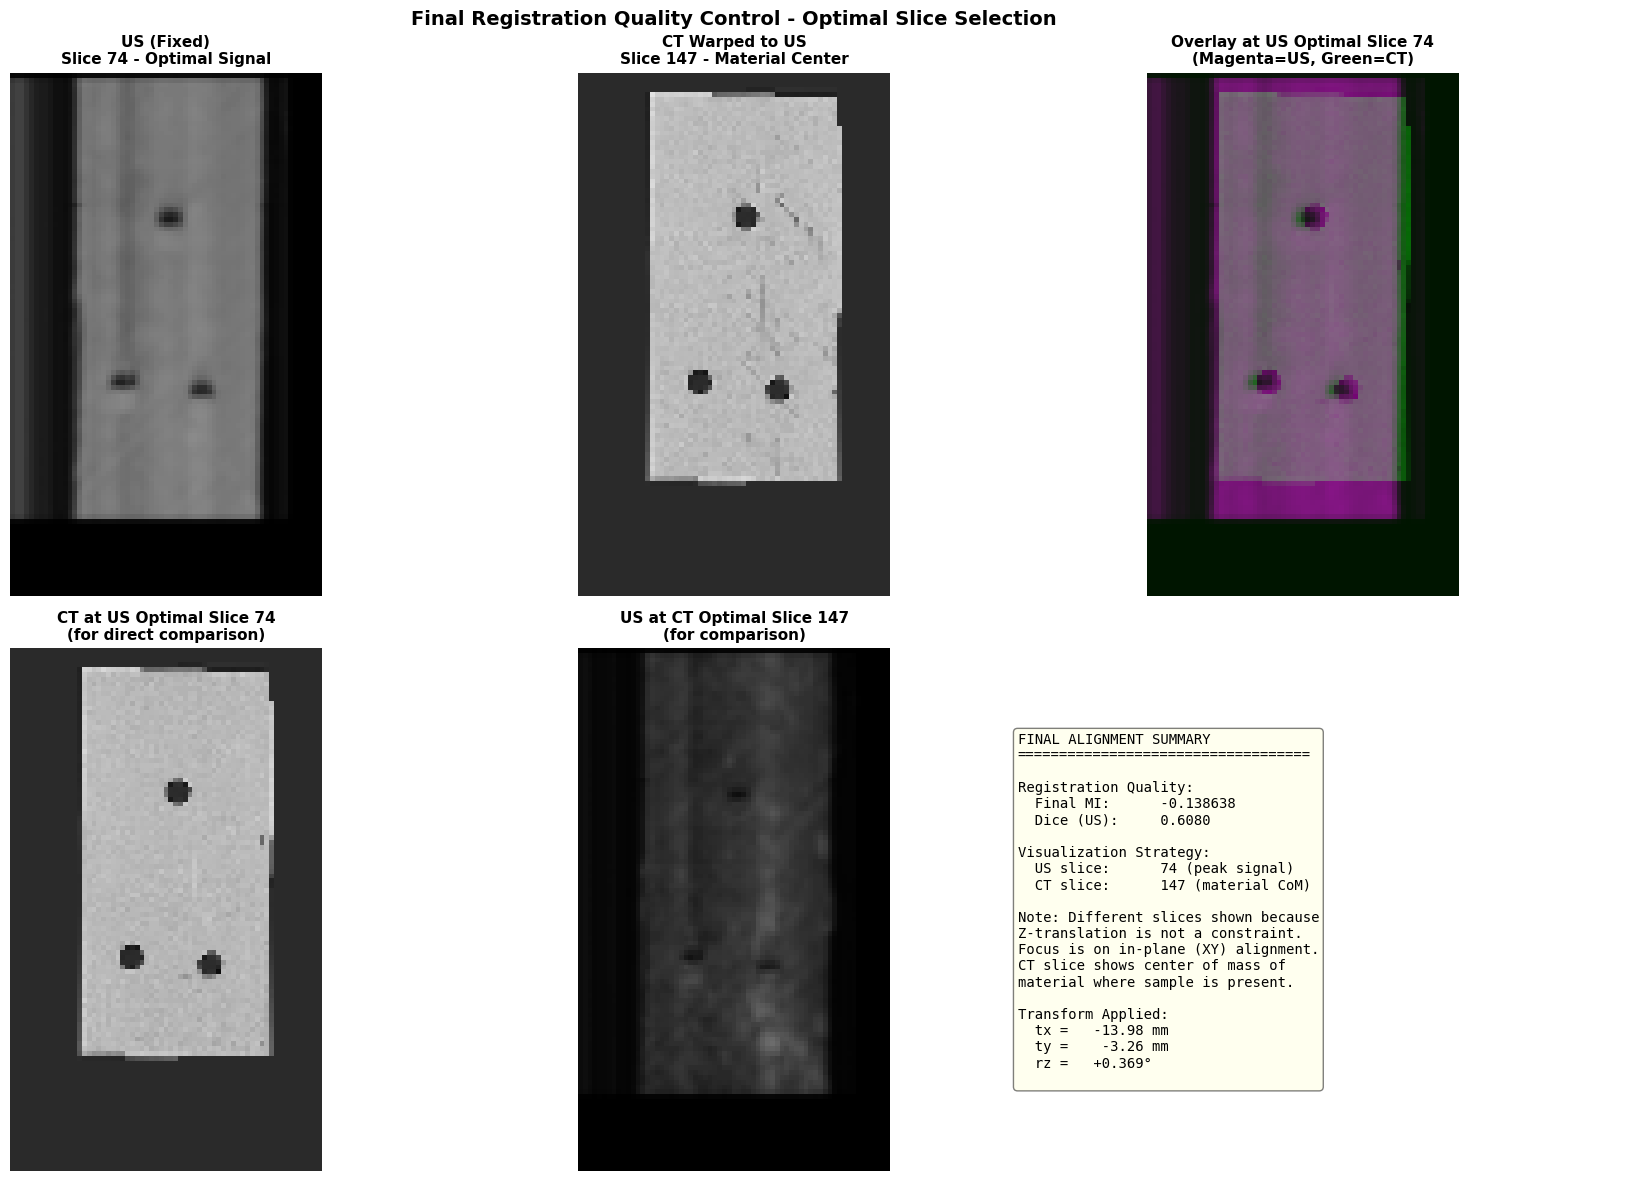


✓ Final QC visualization complete
  US shown at optimal slice 74 (strongest signal)
  CT shown at optimal slice 147 (material center of mass)


In [230]:
# QC: Visualize Final Alignment (Stage 2)
# =========================================

print("\n" + "="*70)
print("FINAL QC: Best Slice Visualization")
print("="*70)

# Get arrays
us_final_arr = sitk.GetArrayFromImage(us_fine_norm)
ct_final_arr = sitk.GetArrayFromImage(ct_in_us_norm)

# Normalize for display
us_final_arr = (us_final_arr - us_final_arr.min()) / (us_final_arr.max() - us_final_arr.min() + 1e-8)
ct_final_arr = (ct_final_arr - ct_final_arr.min()) / (ct_final_arr.max() - ct_final_arr.min() + 1e-8)

# Find optimal US slice (mean of max indices - where signal is strongest)
max_indices_final = np.argmax(us_final_arr, axis=0)
us_optimal_slice = int(np.round(np.mean(max_indices_final)))
us_optimal_slice = np.clip(us_optimal_slice, 0, us_final_arr.shape[0] - 1)
print(f"  US optimal slice: {us_optimal_slice}/{us_final_arr.shape[0]} (mean of max signal indices)")

# CT: find optimal slice where material is present
# Get CT mask in US space for optimal slice selection
ct_mask_in_us_arr = sitk.GetArrayFromImage(ct_mask_in_us)
ct_optimal_slice = find_optimal_ct_slice(ct_final_arr, ct_mask_in_us_arr)
print(f"  CT optimal slice: {ct_optimal_slice}/{ct_final_arr.shape[0]} (center of mass of material)")

# Create visualization with different slices for US and CT
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Individual slices
axes[0, 0].imshow(us_final_arr[us_optimal_slice], cmap='gray', vmin=0, vmax=1)
axes[0, 0].set_title(f'US (Fixed)\nSlice {us_optimal_slice} - Optimal Signal', fontsize=11, weight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(ct_final_arr[ct_optimal_slice], cmap='gray', vmin=0, vmax=1)
axes[0, 1].set_title(f'CT Warped to US\nSlice {ct_optimal_slice} - Material Center', fontsize=11, weight='bold')
axes[0, 1].axis('off')

# Overlay using US optimal slice and corresponding CT slice
overlay_rgb_us = create_overlay_rgb(us_final_arr[us_optimal_slice], ct_final_arr[us_optimal_slice], alpha=0.5)
axes[0, 2].imshow(overlay_rgb_us)
axes[0, 2].set_title(f'Overlay at US Optimal Slice {us_optimal_slice}\n(Magenta=US, Green=CT)', fontsize=11, weight='bold')
axes[0, 2].axis('off')

# Row 2: Additional views
# Show CT at US optimal slice for direct comparison
axes[1, 0].imshow(ct_final_arr[us_optimal_slice], cmap='gray', vmin=0, vmax=1)
axes[1, 0].set_title(f'CT at US Optimal Slice {us_optimal_slice}\n(for direct comparison)', fontsize=11, weight='bold')
axes[1, 0].axis('off')

# Show US at CT optimal slice for comparison
axes[1, 1].imshow(us_final_arr[ct_optimal_slice], cmap='gray', vmin=0, vmax=1)
axes[1, 1].set_title(f'US at CT Optimal Slice {ct_optimal_slice}\n(for comparison)', fontsize=11, weight='bold')
axes[1, 1].axis('off')

# Text panel with final statistics
axes[1, 2].axis('off')
final_stats_text = (
    f'FINAL ALIGNMENT SUMMARY\n'
    f'{"="*35}\n\n'
    f'Registration Quality:\n'
    f'  Final MI:      {metrics_s2[-1]:.6f}\n'
    f'  Dice (US):     {dice_us_space:.4f}\n\n'
    f'Visualization Strategy:\n'
    f'  US slice:      {us_optimal_slice} (peak signal)\n'
    f'  CT slice:      {ct_optimal_slice} (material CoM)\n\n'
    f'Note: Different slices shown because\n'
    f'Z-translation is not a constraint.\n'
    f'Focus is on in-plane (XY) alignment.\n'
    f'CT slice shows center of mass of\n'
    f'material where sample is present.\n\n'
    f'Transform Applied:\n'
    f'  tx = {params_s2[3]:+8.2f} mm\n'
    f'  ty = {params_s2[4]:+8.2f} mm\n'
    f'  rz = {np.rad2deg(params_s2[2]):+8.3f}°\n'
)
axes[1, 2].text(0.05, 0.5, final_stats_text, fontsize=10, verticalalignment='center',
                family='monospace', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))

plt.suptitle('Final Registration Quality Control - Optimal Slice Selection', 
             fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Final QC visualization complete")
print(f"  US shown at optimal slice {us_optimal_slice} (strongest signal)")
print(f"  CT shown at optimal slice {ct_optimal_slice} (material center of mass)")


## Summary

This notebook successfully completes a **2-stage rigid registration** between CT and Ultrasound volumes with in-plane motion constraints:

### Workflow Completed:
1. ✓ **Environment setup** and dependency validation
2. ✓ **Configuration** of all parameters
3. ✓ **Utility functions** loaded (I/O, preprocessing, masks, resampling, etc.)
4. ✓ **Raw volumes** loaded with proper spacing
5. ✓ **Stage 1** (coarse): Isotropic resampling → Full 6-DOF registration → Initial alignment
6. ✓ **Stage 2** (fine): Native US resolution → In-plane constrained registration → Refined alignment
7. ✓ **Inverse transform** computed for bidirectional warping
8. ✓ **Results exported** (transforms, warped volumes, masks)
9. ✓ **Validation** via Dice coefficient
10. ✓ **QC visualizations** of convergence and alignment

### Key Differences from Original:
- **Step-by-step execution**: Each stage broken into separate cells for debugging
- **Transparency**: Can inspect intermediate results at each stage
- **Flexibility**: Can modify individual steps without re-running entire pipeline
- **Educational**: Better understanding of the registration process

### Output Files:
All results saved to the configured output directory with:
- Transform files (`.tfm`)
- Warped volumes (`.tif`)
- Masks
- Metric logs
- Summary report

---

**Note**: To run this notebook, edit Cell 2 (CONFIG) with your data paths and spacings, then execute cells sequentially from Cell 1 to Cell 18.
